### Notebook Preps

In [1]:
%matplotlib inline
#%matplotlib notebook
#%matplotlib nbagg

In [2]:
import re

In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
#import scipy as sp

import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import pickaxe.formatters
from pickaxe.patterns import locality_regex, level_regex, pfx_counter_regex

---

## Read the Data Files

In [4]:
import lzma

In [5]:
def list_files(dir_path, ext):
    for root, dirs, files in os.walk(dir_path):
        for file_name in dirs + files:
            if file_name.endswith(ext):
                yield os.path.join(root, file_name)
            else:
                print('Excluding', file_name)

In [6]:
files_list = list(list_files('long_runs/apr16-queenbee', '.txt.xz'))

Excluding level_11
Excluding level_10
Excluding level_12
Excluding .DS_Store
Excluding o767652.txt
Excluding o765915.txt
Excluding .DS_Store
Excluding o764707.txt
Excluding o764129.txt
Excluding o767459.txt
Excluding o767485.txt
Excluding .DS_Store
Excluding o767889.txt
Excluding o767653.txt
Excluding .DS_Store
Excluding o765916.txt
Excluding o764131.txt
Excluding o763845.txt
Excluding o763667.txt
Excluding o765448.txt


In [7]:
fn = files_list[0]
print(fn)
content = lzma.open(fn, mode='rt', encoding='utf-8').read()

long_runs/apr16-queenbee/level_11/o763668.txt.xz


In [8]:
dataset = []

for fn in list_files('short_runs', '.txt.xz'):
    with lzma.open(fn, mode='rt', encoding='utf-8') as arxiv:
        content = arxiv.read()

        def get_locality_count():
            localities = set(int(x) for x in locality_regex.findall(content))
            if len(localities) == 0:
                raise UserWarning('Unable to find AGAS locality counter data')
            return max(localities) + 1
        try:
            node_count = get_locality_count()
        except UserWarning:
            print('No AGAS locality counters found in "%s". Skipping...' % fn)
            continue
        print('Processing "%s"...' % fn)

        def get_max_level():
            max_level_m = level_regex.search(content)
            assert max_level_m
            return int(max_level_m[1])
        max_level = get_max_level()
        
        for m in pfx_counter_regex.finditer(content):
            is_rev = m.group(3) != None

            dataset.append({
                'sys': m.group(1),
                'proc': (m.group(4) if is_rev else m.group(5)).replace('/', '.'),
                'type': m.group(3) if is_rev else m.group(6),
                'locality': int(m.group(2)),
                'value': float(m.group(9)),
                'value_unit': m.group(10),
                'timestamp': float(m.group(8)),
                'iteration': int(m.group(7)),
                'nodes': node_count,
                'max_level': max_level,
                })

df = pd.DataFrame(dataset)

Excluding cori
Excluding .DS_Store
Excluding .DS_Store


NameError: name 'locality_regex' is not defined

```python
dataset = []

with zipfile.ZipFile('daint-28mar19_14_15.zip', 'r') as arxiv:
    for fn in arxiv.namelist():
        if fn.endswith('.out'):
            content = arxiv.read(fn).decode('utf-8')
            content = arxiv.read(fn).decode('utf-8')
            localities = set(int(x) for x in locality_regex.findall(content))
            if (localities):
                print('Processing "%s"...' % fn)
            else:
                print('No data found in "%s". Skipping...' % fn)
                continue
            node_count = max(localities) + 1
            
            for m in pfx_counter_regex.finditer(content):
                is_rev = m.group(3) != None

                dataset.append({
                    'sys': m.group(1),
                    'proc': (m.group(4) if is_rev else m.group(5)).replace('/', '.'),
                    'type': m.group(3) if is_rev else m.group(6),
                    'locality': int(m.group(2)),
                    'value': float(m.group(9)),
                    'value_unit': m.group(10),
                    'timestamp': float(m.group(8)),
                    'iteration': int(m.group(7)),
                    'nodes': node_count,
                })

df = pd.DataFrame(dataset)
```

```python
import tarfile

dataset = []

with tarfile.open('cori-17mar17.tar.bz2', mode='r:bz2') as arxiv:
    for i in arxiv.getnames():
        if i.endswith('.txt'):
            n_nodes = int(i.split('.')[0])
            fd = arxiv.extractfile(i)
            for m in pfx_pattern.finditer(fd.read()):
                is_rev = m.group(3) != None

                dataset.append({
                    'sys': m.group(1),
                    'proc': (m.group(4) if is_rev else m.group(5)).replace('/', '.'),
                    'type': m.group(3) if is_rev else m.group(6),
                    'locality': int(m.group(2)),
                    'value': float(m.group(9)),
                    'value_unit': m.group(10),
                    'timestamp': m.group(8),
                    'iteration': int(m.group(7)),
                    'nodes': n_nodes,
                })

df = pd.DataFrame(dataset)
```

### Last Iteration

In [13]:
assert df.iteration.max() == 1

```python
d = None
for i, j in df[['nodes', 'iteration']].groupby('nodes').max().iteration.to_dict().items():
    x = df[(df.nodes==i) & (df.iteration==j)]
    if d is None:
        d = x
    else:
        d = pd.concat([d, x])
```

In [14]:
print(df.proc.unique())

['route' 'bind_gid' 'unbind_gid' 'resolve_gid' 'increment_credit'
 'decrement_credit' 'allocate' 'begin_migration' 'end_migration'
 'bind_prefix' 'bind_name' 'unbind_name' 'resolve_id' 'iterate_types'
 'get_component_typename' 'num_localities_type' 'free' 'localities'
 'num_localities' 'resolve_locality' 'num_threads' 'bind' 'unbind'
 'resolve' 'iterate_names' 'on_symbol_namespace_event' 'cache.entries'
 'cache.insertions' 'cache.evictions' 'cache.hits' 'cache.misses'
 'cache.get_entry' 'cache.insert_entry' 'cache.update_entry'
 'cache.erase_entry' 'primary' 'component' 'locality' 'symbol']


In [15]:
print(df[(df.sys=='agas') & (df.type=='count')].proc.unique())
print(df[(df.sys=='agas') & (df.type=='time')].proc.unique())

['route' 'bind_gid' 'unbind_gid' 'resolve_gid' 'increment_credit'
 'decrement_credit' 'allocate' 'begin_migration' 'end_migration'
 'bind_prefix' 'bind_name' 'unbind_name' 'resolve_id' 'iterate_types'
 'get_component_typename' 'num_localities_type' 'free' 'localities'
 'num_localities' 'resolve_locality' 'num_threads' 'bind' 'unbind'
 'resolve' 'iterate_names' 'on_symbol_namespace_event' 'cache.entries'
 'cache.insertions' 'cache.evictions' 'cache.hits' 'cache.misses'
 'cache.get_entry' 'cache.insert_entry' 'cache.update_entry'
 'cache.erase_entry' 'primary' 'component' 'locality' 'symbol']
['route' 'bind_gid' 'unbind_gid' 'resolve_gid' 'decrement_credit'
 'increment_credit' 'allocate' 'begin_migration' 'end_migration'
 'bind_prefix' 'bind_name' 'unbind_name' 'resolve_id' 'iterate_types'
 'get_component_typename' 'num_localities_type' 'free' 'localities'
 'num_localities' 'resolve_locality' 'num_threads' 'bind' 'unbind'
 'resolve' 'iterate_names' 'on_symbol_namespace_event' 'cache.get_

---

### Matplotlib black and white helper

In [18]:
def setAxLinesBW(ax):
    """
    Take each Line2D in the axes, ax, and convert the line style to be 
    suitable for black and white viewing.
    """
    MARKERSIZE = 3

    COLORMAP = {
        '#1f77b4': {'marker': None, 'dash': (None,None)},
        '#ff7f0e': {'marker': None, 'dash': [5,5]},
        '#2ca02c': {'marker': None, 'dash': [5,3,1,3]},
        'c': {'marker': None, 'dash': [1,3]},
        'm': {'marker': None, 'dash': [5,2,5,2,5,10]},
        'y': {'marker': None, 'dash': [5,3,1,2,1,10]},
        'k': {'marker': 'o', 'dash': (None,None)} #[1,2,1,10]}
        }


    lines_to_adjust = ax.get_lines()
    try:
        lines_to_adjust += ax.get_legend().get_lines()
    except AttributeError:
        pass

    for line in lines_to_adjust:
        origColor = line.get_color()
        line.set_color('black')
        line.set_dashes(COLORMAP[origColor]['dash'])
        line.set_marker(COLORMAP[origColor]['marker'])
        line.set_markersize(MARKERSIZE)

def setFigLinesBW(fig):
    """
    Take each axes in the figure, and for each line in the axes, make the
    line viewable in black and white.
    """
    for ax in fig.get_axes():
        setAxLinesBW(ax)

## Total

In [19]:
sorted(df.nodes.unique())

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

In [20]:
x = df[(df.sys=='agas') & (df.nodes==1024) & (df.type=='time') & (df.locality!=0)][['value', 'timestamp']]
100.0 * 1e-9 * x.value.sum() / (x.timestamp.mean() * 20 * 1024)

0.0016713877140809932

In [21]:
max_level_list = sorted(df.max_level.unique())
node_counts_list = sorted(df[df.nodes!=1].nodes.unique())

In [22]:
a = []
for i in node_counts_list:
    v = df[(df.sys=='agas') & (df.nodes==i) & (df.type=='time') & (df.locality!=0)]
    a += [1e-9 * (v.value / v.timestamp).sum() / (i * 24)]
print(a)

[0.07659730202355602, 0.030223460836366355, 0.009168947126361847, 0.0011858211514675489, 0.00017520610872803885, 0.00138597101843673, 0.00024924584653042653, 0.00012348302633831824, 6.808711107454583e-05, 1.3843857978735876e-05]


In [24]:
max_level_list.remove(12)

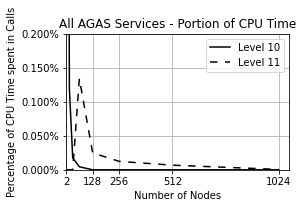

In [26]:
fig = plt.figure(figsize=(4, 2.5))
for level in max_level_list:
    a = []
    for i in node_counts_list:
        v = df[(df.sys=='agas') & (df.nodes==i) & (df.type=='time') & (df.max_level==level) & (df.locality!=0)]
        a += [1e-9 * (v.value / v.timestamp).sum() / (i * 24)]
    plt.plot(node_counts_list, a, label='Level {}'.format(level))

plt.grid()

plt.title('All AGAS Services - Portion of CPU Time')
plt.xlabel('Number of Nodes')
plt.ylabel('Percentage of CPU Time spent in Calls')

plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1))
plt.gca().xaxis.set_major_locator(ticker.FixedLocator([2, 128, 256, 512, 1024]))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0., top=.002)

plt.legend(loc='upper right')

setFigLinesBW(fig)

plt.savefig('octotiger_runtime_proportion.pdf')

## GIDs

### Bind GID

(0.0, 584.3060706401767)

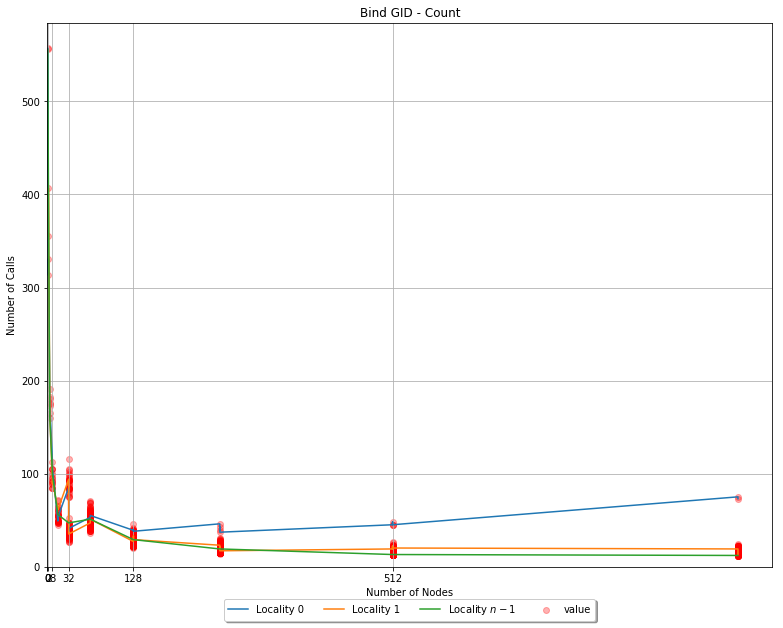

In [12]:
crt = d[(d.sys=='agas') & (d.proc=='bind_gid') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Bind GID - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

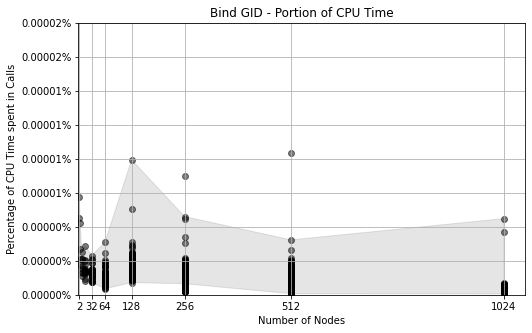

In [73]:
crt = df[(df.sys=='agas') & (df.proc=='bind_gid') & (df.type=='time')]
t = (1e-9 * crt.value / crt.timestamp) / 24.

plt.figure(figsize=(8, 5))
plt.scatter(crt.nodes, t, c='0', alpha=.5)

og = crt.sort_values(by='value', ascending=False).groupby('nodes', as_index=False)
y1 = (1e-9 * og.first().value / og.first().timestamp) / 24.
y2 = (1e-9 * og.last().value / og.last().timestamp) / 24.
#plt.fill_between(crt.nodes, t, facecolor='r', alpha=.1)
plt.fill_between(og.groups.keys(), y1, y2, label='Other Localities', alpha=.1, color='0')

plt.grid()

#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Bind GID - Portion of CPU Time')
plt.xlabel('Number of Nodes')
plt.ylabel('Percentage of CPU Time spent in Calls')

plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1))
plt.gca().xaxis.set_major_locator(ticker.FixedLocator([2, 32, 64, 128, 256, 512, 1024]))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0., top=.0000002)

plt.savefig('octotiger_bind_gid_time.pdf')

(0.0, 2000000.0)

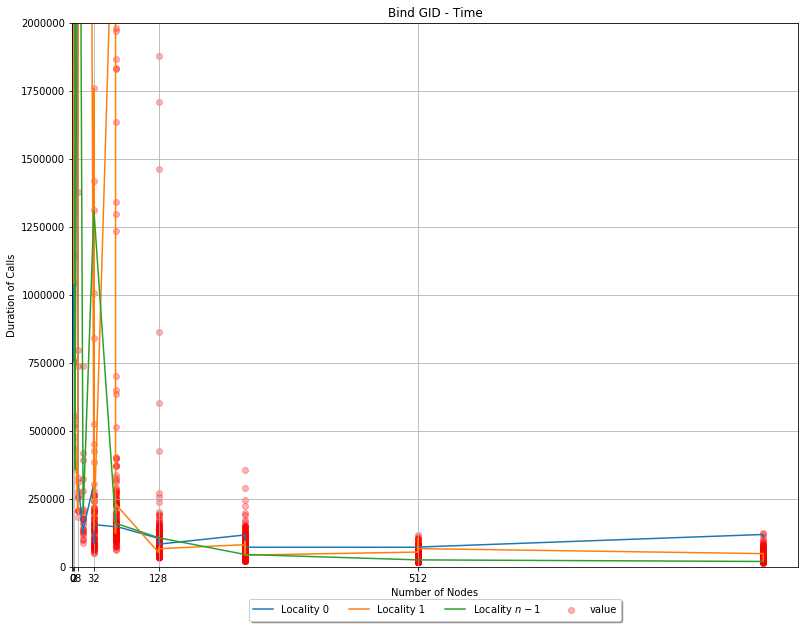

In [16]:
crt = d[(d.sys=='agas') & (d.proc=='bind_gid') & (d.type=='time')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Bind GID - Time')
plt.xlabel('Number of Nodes')
plt.ylabel('Duration of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0., top=2e6)

[^ TOC ^](#Counters)

### Unbind GID

(0.0, 553.3560706401767)

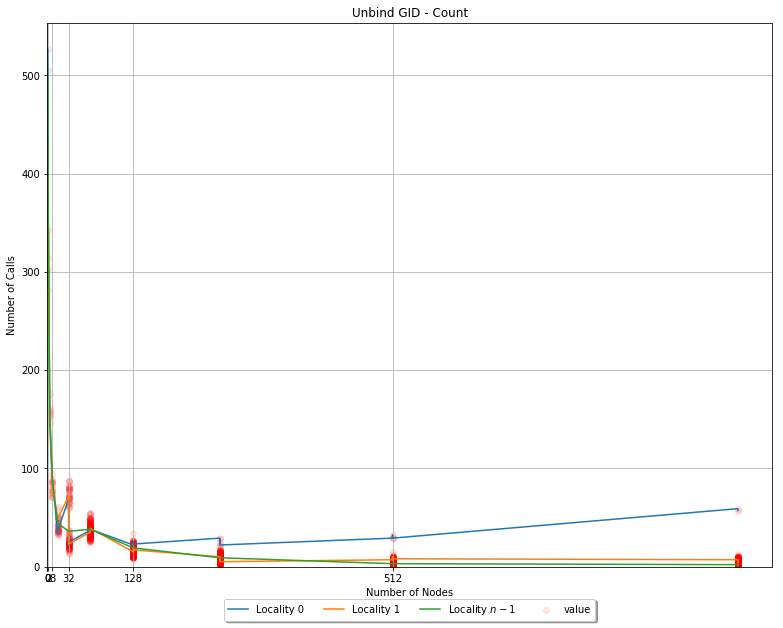

In [13]:
crt = d[(d.sys=='agas') & (d.proc=='unbind_gid') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.1)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Unbind GID - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

### Resolve GID

(0.0, 44913904.60607064)

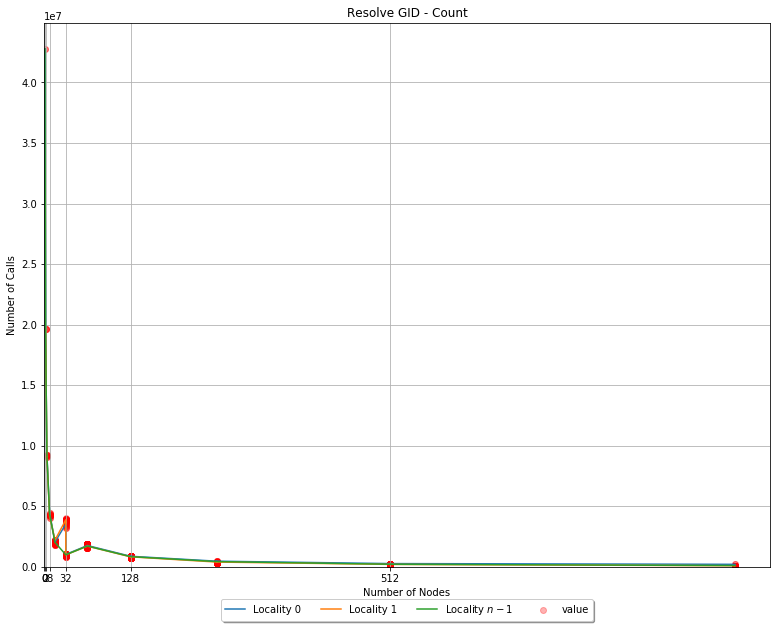

In [305]:
crt = d[(d.sys=='agas') & (d.proc=='resolve_gid') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Resolve GID - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

In [301]:
crt[(crt.nodes == 1)]

iteration  locality  nodes         proc   sys   timestamp  type  \
264031          1         0      1  resolve_gid  agas  249.395694  time   
264104          1         0      1  resolve_gid  agas  248.568662  time   

               value value_unit  
264031  9.436940e+10         ns  
264104  8.950760e+10         ns

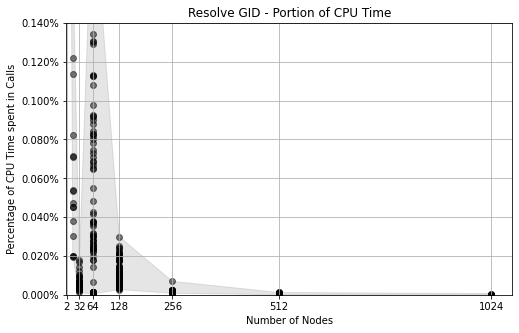

In [87]:
crt = df[(df.sys=='agas') & (df.proc=='resolve_gid') & (df.type=='time')]
t = (1e-9 * crt.value / crt.timestamp) / 24.

plt.figure(figsize=(8, 5))
plt.scatter(crt.nodes, t, c='0', alpha=.5)

og = crt.sort_values(by='value', ascending=False).groupby('nodes', as_index=False)
y1 = (1e-9 * og.first().value / og.first().timestamp) / 24.
y2 = (1e-9 * og.last().value / og.last().timestamp) / 24.
plt.fill_between(og.groups.keys(), y1, y2, label='Other Localities', alpha=.1, color='0')
#
plt.grid()

plt.title('Resolve GID - Portion of CPU Time')
plt.xlabel('Number of Nodes')
plt.ylabel('Percentage of CPU Time spent in Calls')

plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1))
plt.gca().xaxis.set_major_locator(ticker.FixedLocator([2, 32, 64, 128, 256, 512, 1024]))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0., top=.0014)
plt.savefig('octotiger_resolve_gid_time.pdf', format='pdf')

[^ TOC ^](#Counters)

---

## Garbage Collection

### Increment Credit

(0.0, 1302.0060706401766)

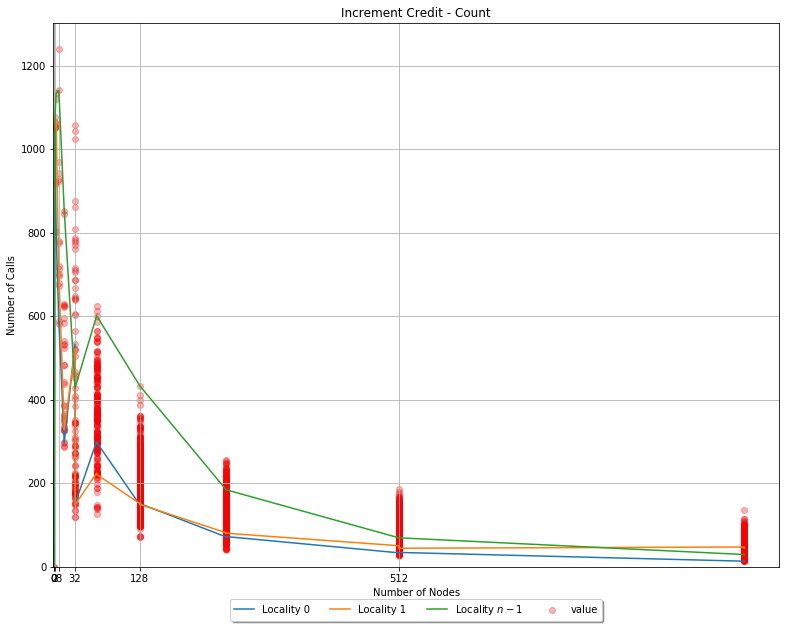

In [16]:
crt = d[(d.sys=='agas') & (d.proc=='increment_credit') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Increment Credit - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

(0.0, 1217496.0060706402)

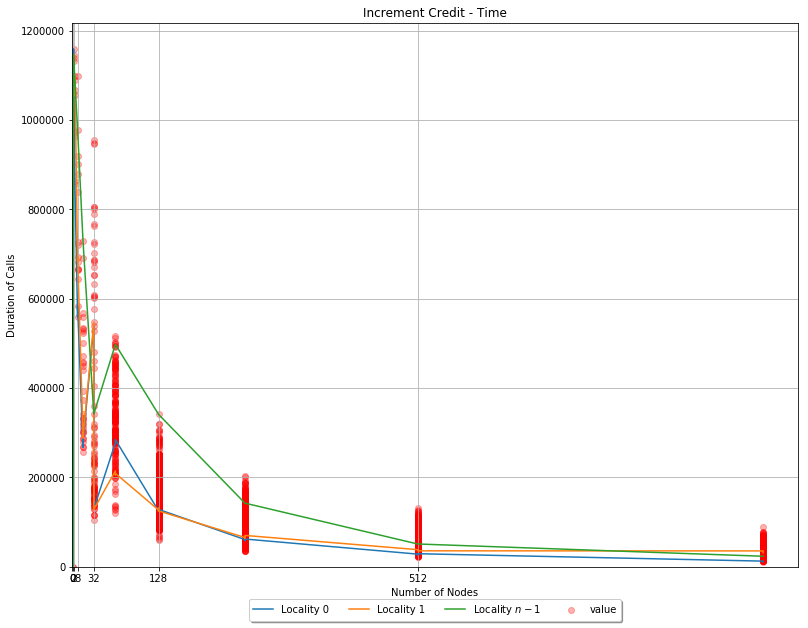

In [17]:
crt = d[(d.sys=='agas') & (d.proc=='increment_credit') & (d.type=='time')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Increment Credit - Time')
plt.xlabel('Number of Nodes')
plt.ylabel('Duration of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

### Decrement Credit

(0.0, 2609.056070640177)

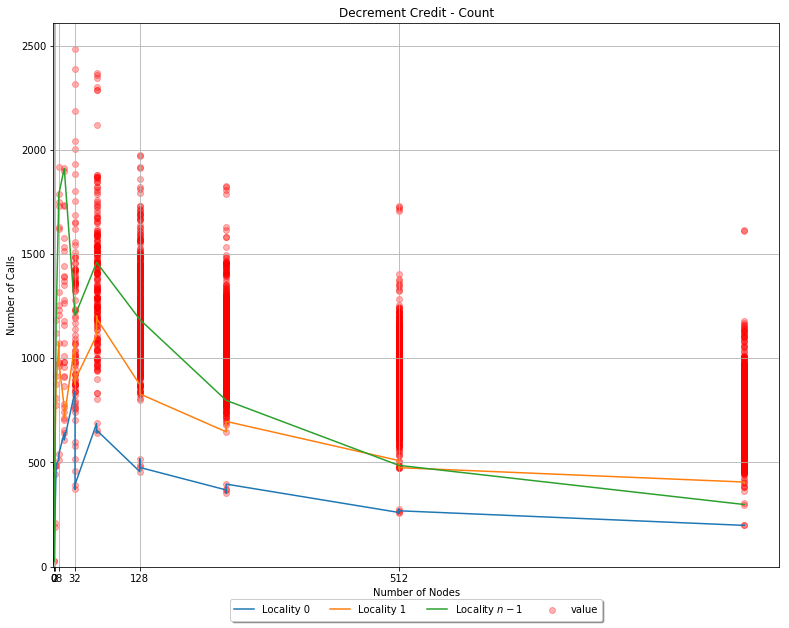

In [18]:
crt = d[(d.sys=='agas') & (d.proc=='decrement_credit') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Decrement Credit - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

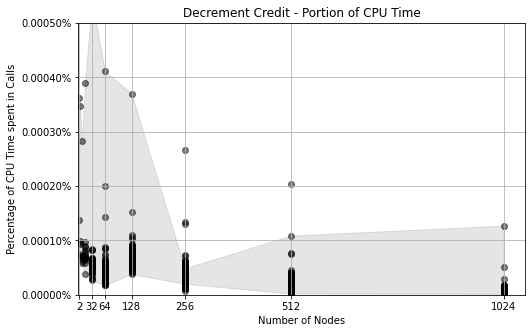

In [89]:
crt = df[(df.sys=='agas') & (df.proc=='decrement_credit') & (df.type=='time')]
t = (1e-9 * crt.value / crt.timestamp) / 24.

plt.figure(figsize=(8, 5))
plt.scatter(crt.nodes, t, c='0', alpha=.5)

og = crt.sort_values(by='value', ascending=False).groupby('nodes', as_index=False)
y1 = (1e-9 * og.first().value / og.first().timestamp) / 24.
y2 = (1e-9 * og.last().value / og.last().timestamp) / 24.
plt.fill_between(og.groups.keys(), y1, y2, label='Other Localities', alpha=.1, color='0')
#
plt.grid()

plt.title('Decrement Credit - Portion of CPU Time')
plt.xlabel('Number of Nodes')
plt.ylabel('Percentage of CPU Time spent in Calls')

plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1))
plt.gca().xaxis.set_major_locator(ticker.FixedLocator([2, 32, 64, 128, 256, 512, 1024]))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0., top=0.000005)

plt.savefig('octotiger_decrement_credit_time.pdf')

[^ TOC ^](#Counters)

---

## Locality Namespace

### Route

(0.0, 1479.4560706401767)

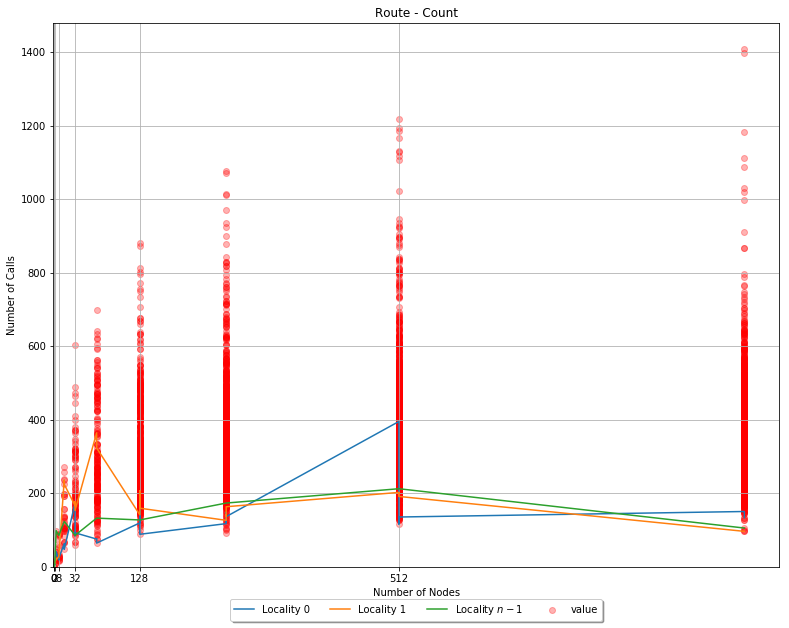

In [227]:
crt = d[(d.sys=='agas') & (d.proc=='route') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Route - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

In [291]:
for i, j in enumerate(crt[crt.locality==0].value):
    print(i, int(j), hex(int(j)))

0 0x15f8dac4c0
1 0x14d7119680
2 0x5ff380d60
3 0x5a9ae2a00
4 0x2036671a0
5 0x1ffc8d880
6 0x7c9c7b70
7 0x8476faf0
8 0x2fe9bb58
9 0x2ca37d80
10 0x5f3fb290
11 0x154fcb98
12 0x1424b530
13 0x2315b080
14 0x277bc9c0
15 0x2cddded0
16 0x11d834f0
17 0x132b1ac0
18 0x120e0e18
19 0x1521e598
20 0xa085818
21 0xa39dfc8
22 0x9c63668
23 0x95f5a60
24 0x6196e90
25 0x64b9e38
26 0x5ef68c0
27 0x5eccb9c
28 0x3e423b8
29 0x41bab58


Exclude locality 0 measurements for route time. The measurements are obviously wrong.

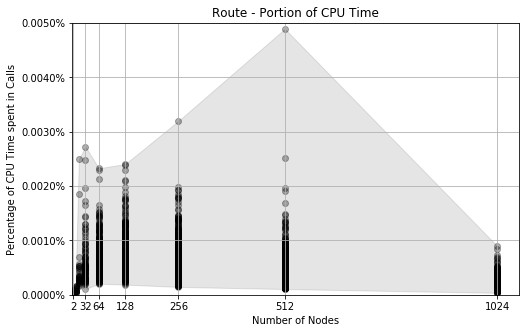

In [213]:
crt = d[(d.sys=='agas') & (d.proc=='route') & (d.type=='time') & (d.locality!=0)]
t = (1e-9 * crt.value / crt.timestamp) / 24.

plt.figure(figsize=(8, 5))
plt.scatter(crt.nodes, t, c='0', alpha=.3)

og = crt.sort_values(by='value', ascending=False).groupby('nodes', as_index=False)
y1 = (1e-9 * og.first().value / og.first().timestamp) / 24.
y2 = (1e-9 * og.last().value / og.last().timestamp) / 24.
plt.fill_between(og.groups.keys(), y1, y2, label='Other Localities', alpha=.1, color='0')
#
#t = crt[crt.locality==0]
#plt.plot(t.nodes, (1e-9 * t.value / t.timestamp) / 24., label='Locality 0')
#
plt.grid()

#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Route - Portion of CPU Time')
plt.xlabel('Number of Nodes')
plt.ylabel('Percentage of CPU Time spent in Calls')

plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1))
plt.gca().xaxis.set_major_locator(ticker.FixedLocator([2, 32, 64, 128, 256, 512, 1024]))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0., top=.00005)

plt.savefig('../graphs/octotiger_route_time.pdf')

[^ TOC ^](#Counters)

### Allocate

(0.0, 23.656070640176605)

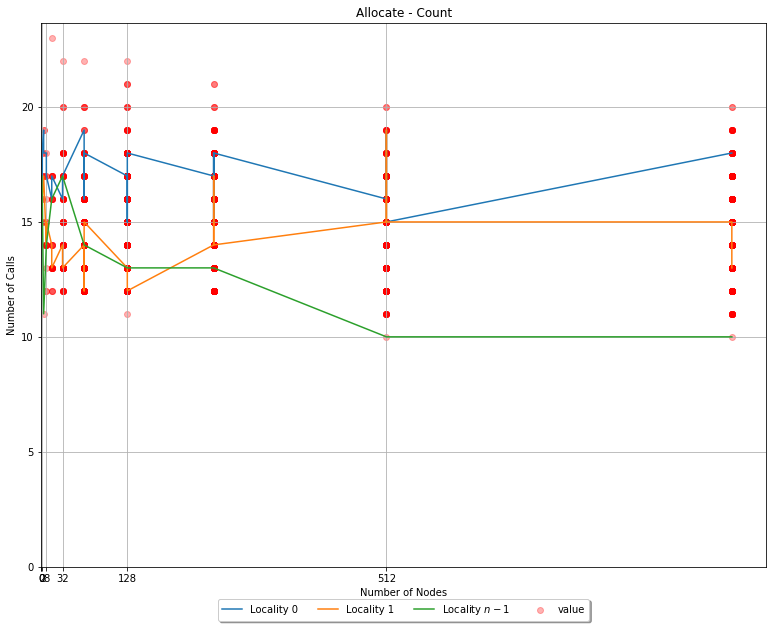

In [22]:
crt = d[(d.sys=='agas') & (d.proc=='allocate') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Allocate - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

(0.0, 11905.406070640176)

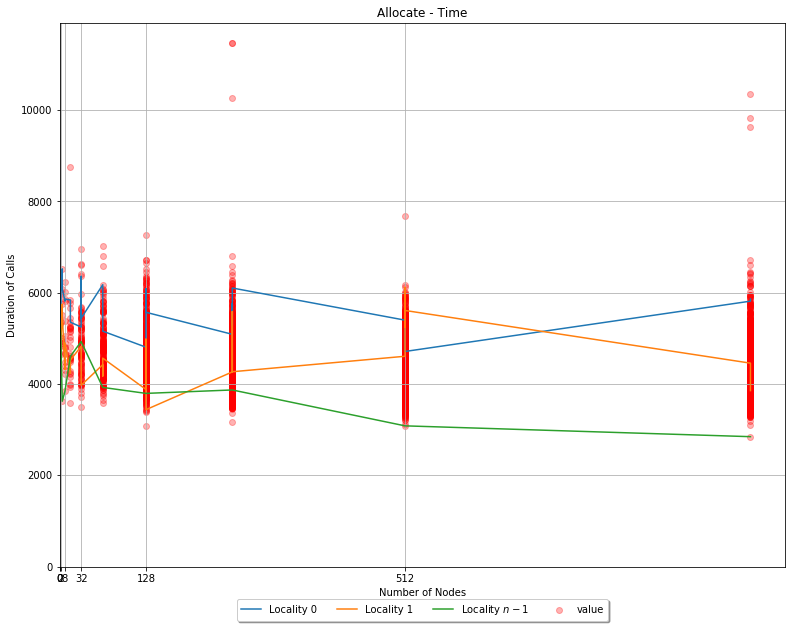

In [23]:
crt = d[(d.sys=='agas') & (d.proc=='allocate') & (d.type=='time')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Allocate - Time')
plt.xlabel('Number of Nodes')
plt.ylabel('Duration of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

## Migration

### Begin Migration

(0.0, 0.006070640176600442)

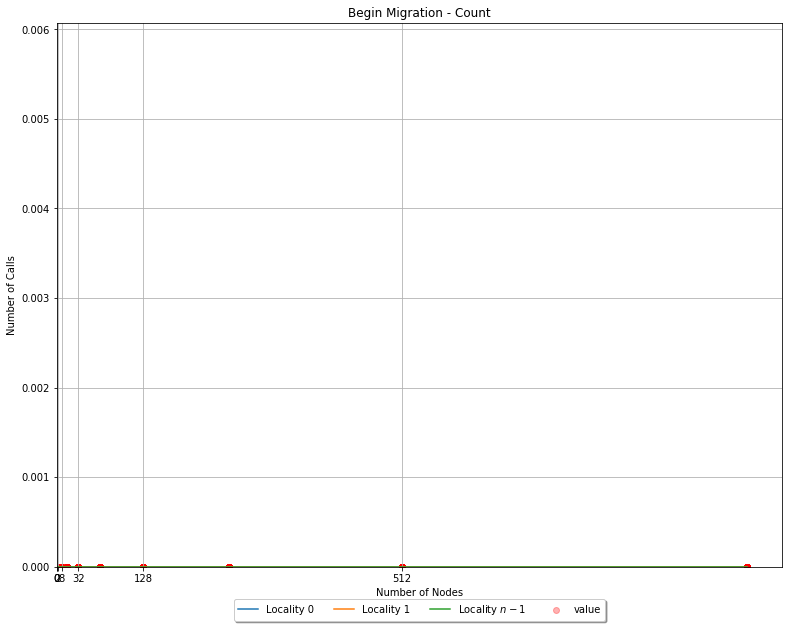

In [24]:
crt = d[(d.sys=='agas') & (d.proc=='begin_migration') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Begin Migration - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

(0.0, 0.006070640176600442)

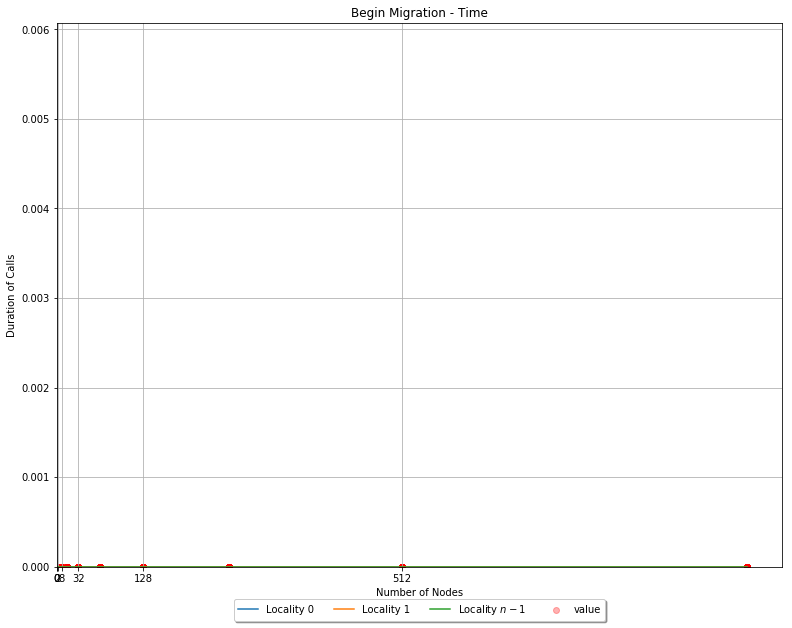

In [25]:
crt = d[(d.sys=='agas') & (d.proc=='begin_migration') & (d.type=='time')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Begin Migration - Time')
plt.xlabel('Number of Nodes')
plt.ylabel('Duration of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

### End Migration

(0.0, 0.006070640176600442)

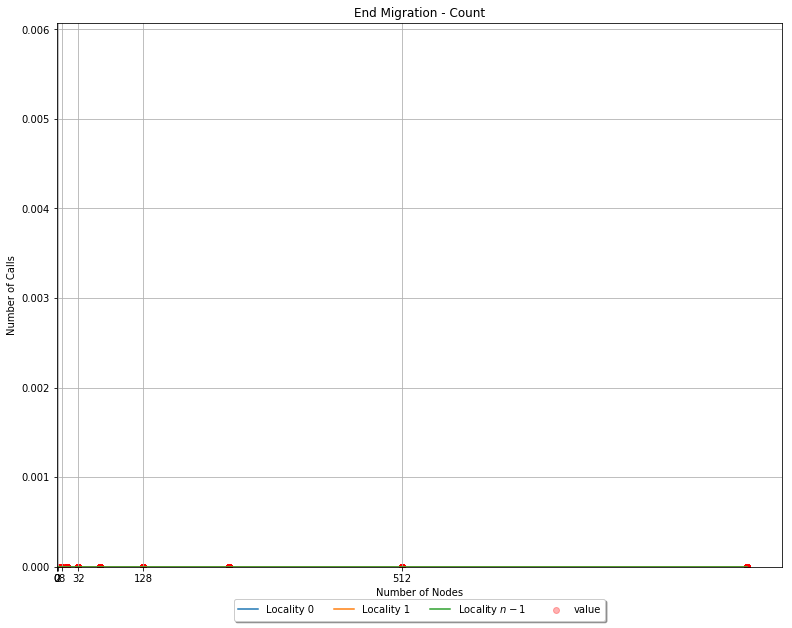

In [26]:
crt = d[(d.sys=='agas') & (d.proc=='end_migration') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('End Migration - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

(0.0, 0.006070640176600442)

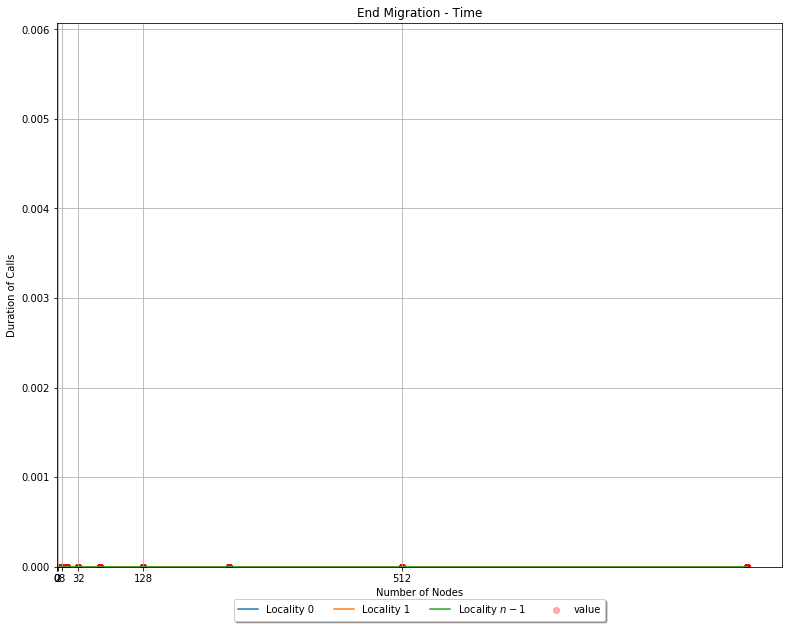

In [27]:
crt = d[(d.sys=='agas') & (d.proc=='end_migration') & (d.type=='time')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('End Migration - Time')
plt.xlabel('Number of Nodes')
plt.ylabel('Duration of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

## Component Namespace

### Bind Prefix

(0.0, 0.006070640176600442)

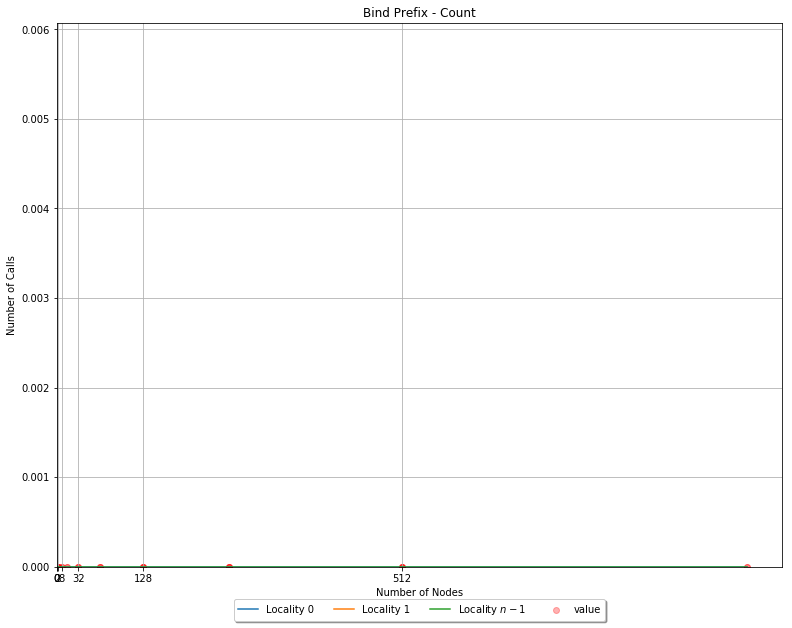

In [28]:
crt = d[(d.sys=='agas') & (d.proc=='bind_prefix') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Bind Prefix - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

(0.0, 0.006070640176600442)

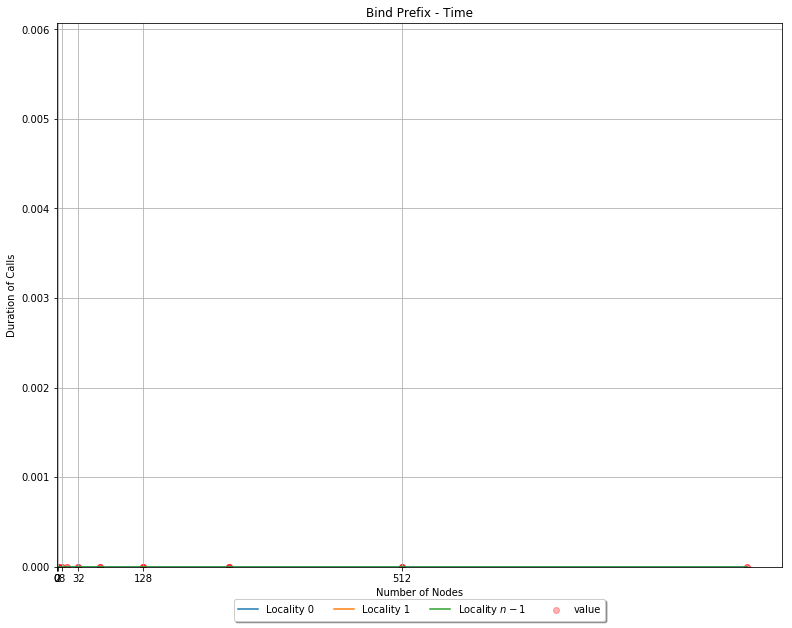

In [29]:
crt = d[(d.sys=='agas') & (d.proc=='bind_prefix') & (d.type=='time')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Bind Prefix - Time')
plt.xlabel('Number of Nodes')
plt.ylabel('Duration of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

### Bind Name

(0.0, 0.006070640176600442)

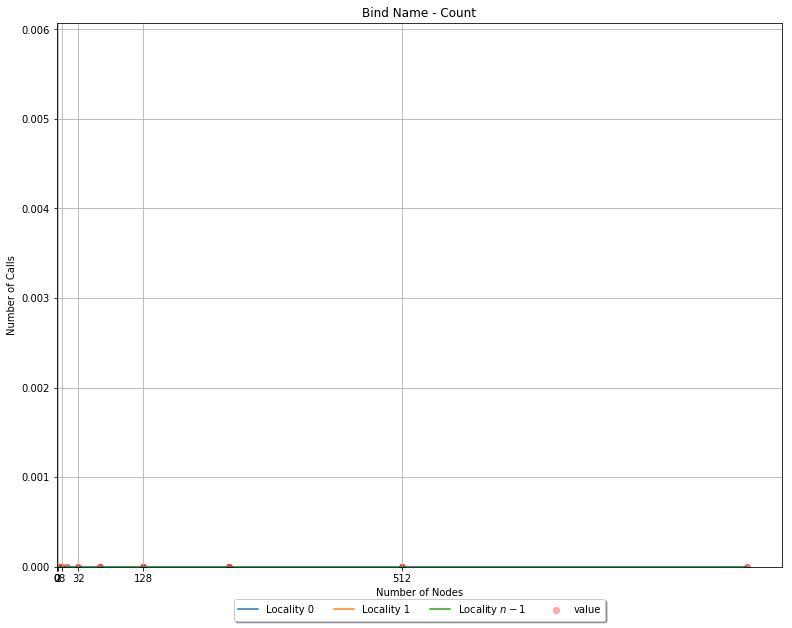

In [30]:
crt = d[(d.sys=='agas') & (d.proc=='bind_name') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Bind Name - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

(0.0, 0.006070640176600442)

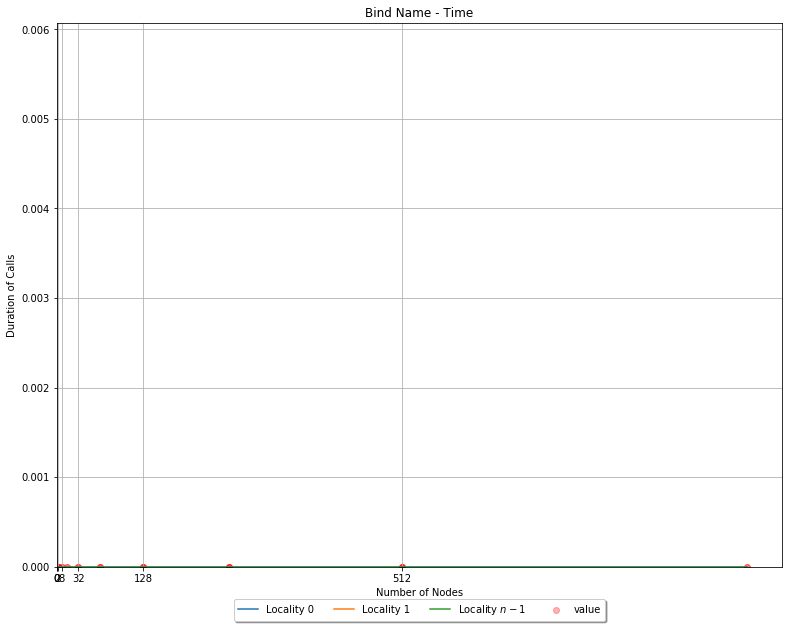

In [31]:
crt = d[(d.sys=='agas') & (d.proc=='bind_name') & (d.type=='time')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Bind Name - Time')
plt.xlabel('Number of Nodes')
plt.ylabel('Duration of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

### Unbind Name

(0.0, 0.006070640176600442)

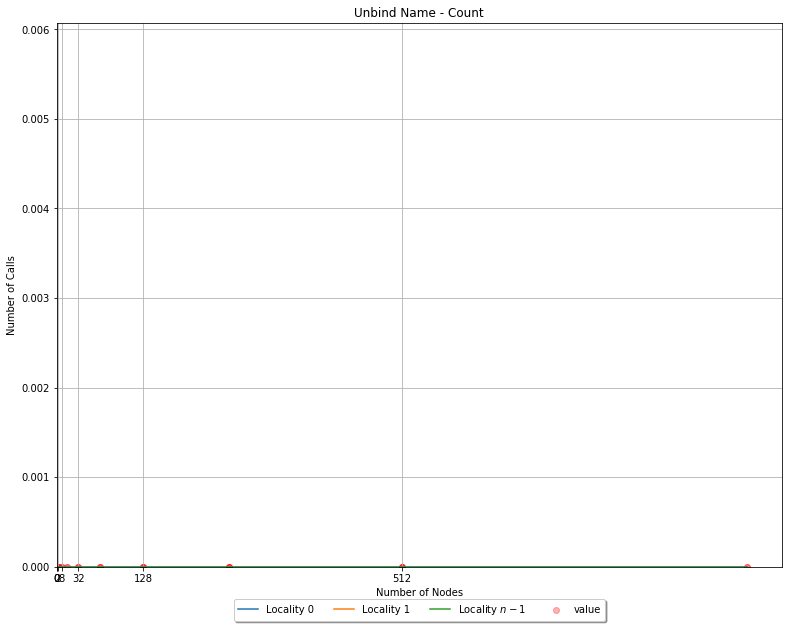

In [32]:
crt = d[(d.sys=='agas') & (d.proc=='unbind_name') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Unbind Name - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

(0.0, 0.006070640176600442)

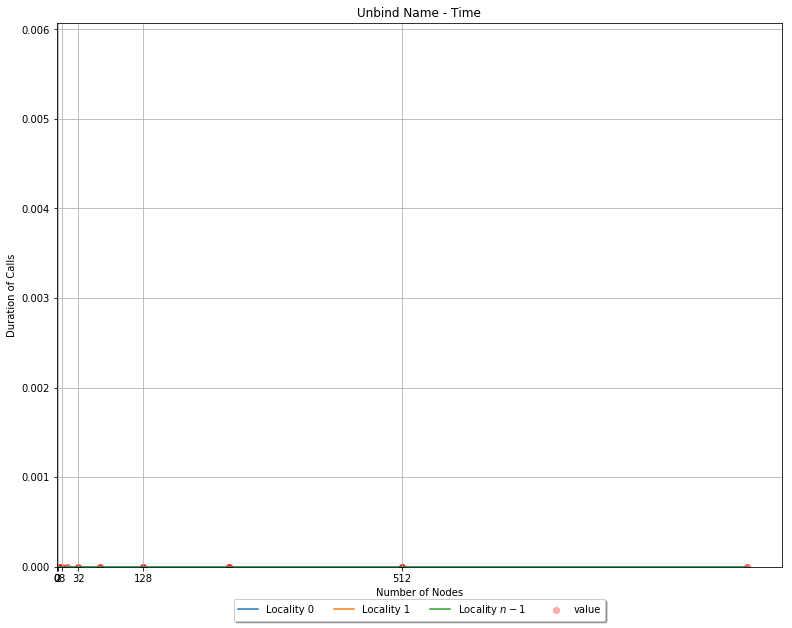

In [33]:
crt = d[(d.sys=='agas') & (d.proc=='unbind_name') & (d.type=='time')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Unbind Name - Time')
plt.xlabel('Number of Nodes')
plt.ylabel('Duration of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

### Resolve ID

(0.0, 0.006070640176600442)

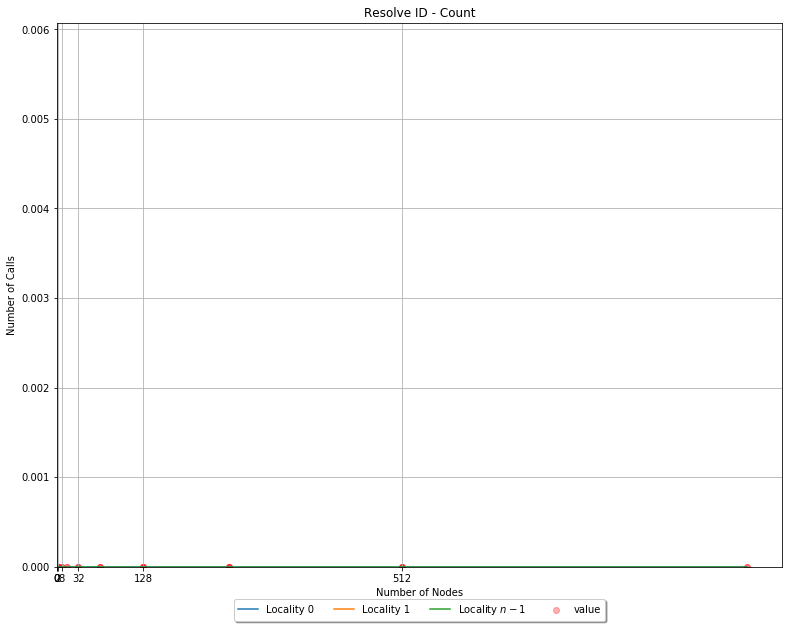

In [34]:
crt = d[(d.sys=='agas') & (d.proc=='resolve_id') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Resolve ID - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

(0.0, 0.006070640176600442)

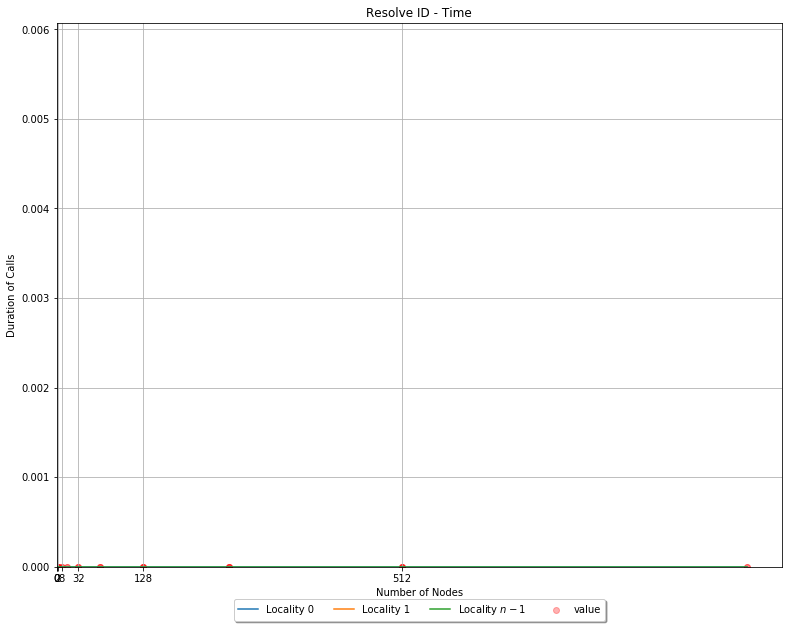

In [35]:
crt = d[(d.sys=='agas') & (d.proc=='resolve_id') & (d.type=='time')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Resolve ID - Time')
plt.xlabel('Number of Nodes')
plt.ylabel('Duration of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

### Iterate Types

(0.0, 0.006070640176600442)

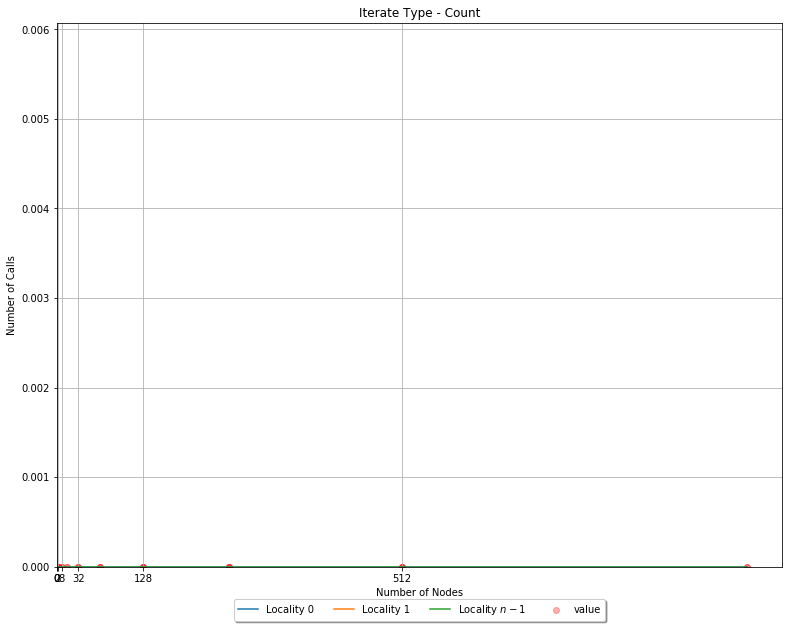

In [36]:
crt = d[(d.sys=='agas') & (d.proc=='iterate_types') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Iterate Type - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

(0.0, 0.006070640176600442)

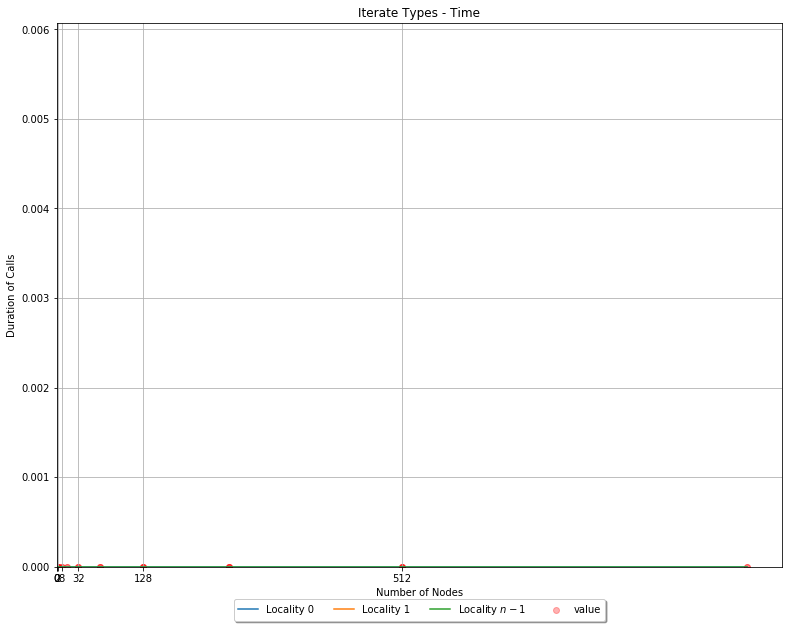

In [37]:
crt = d[(d.sys=='agas') & (d.proc=='iterate_types') & (d.type=='time')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Iterate Types - Time')
plt.xlabel('Number of Nodes')
plt.ylabel('Duration of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

### Get Component Type Name

(0.0, 0.006070640176600442)

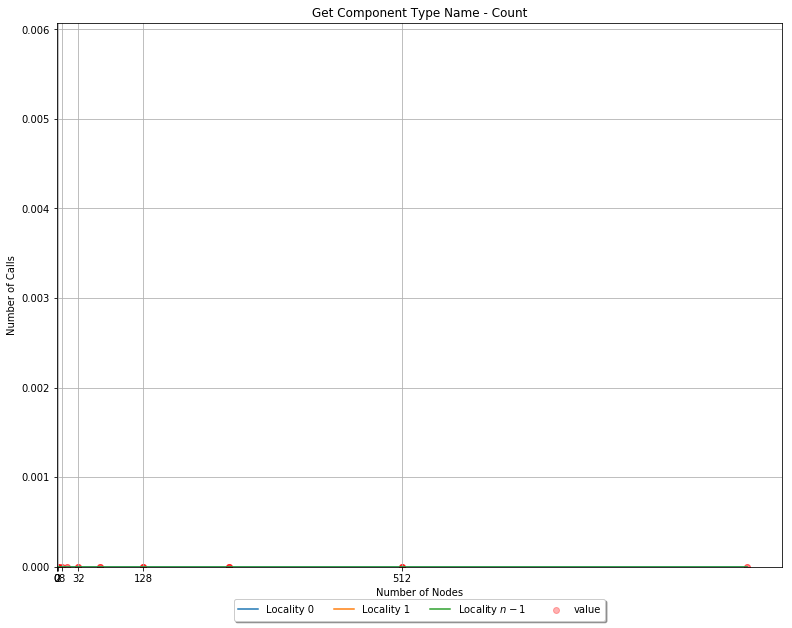

In [38]:
crt = d[(d.sys=='agas') & (d.proc=='get_component_typename') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Get Component Type Name - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

(0.0, 0.006070640176600442)

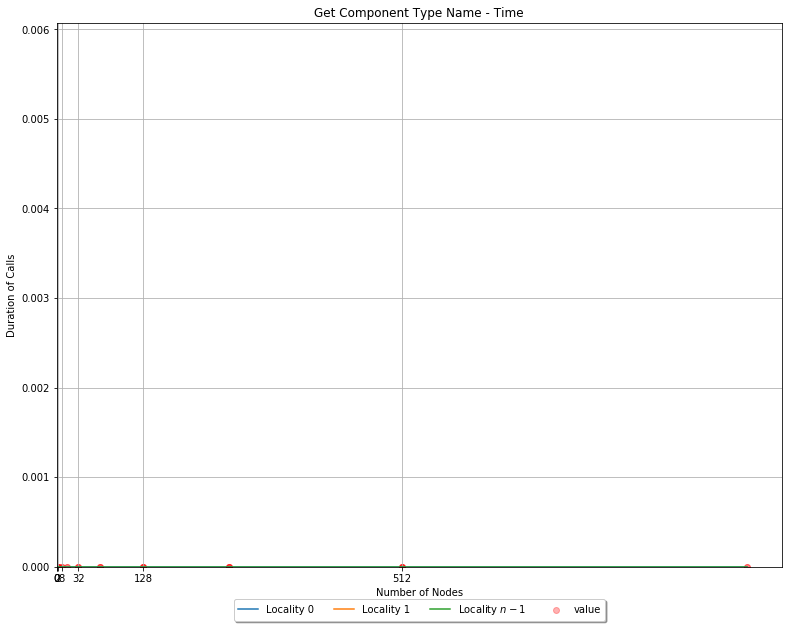

In [39]:
crt = d[(d.sys=='agas') & (d.proc=='get_component_typename') & (d.type=='time')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Get Component Type Name - Time')
plt.xlabel('Number of Nodes')
plt.ylabel('Duration of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

### Number of Locality Type

(0.0, 0.006070640176600442)

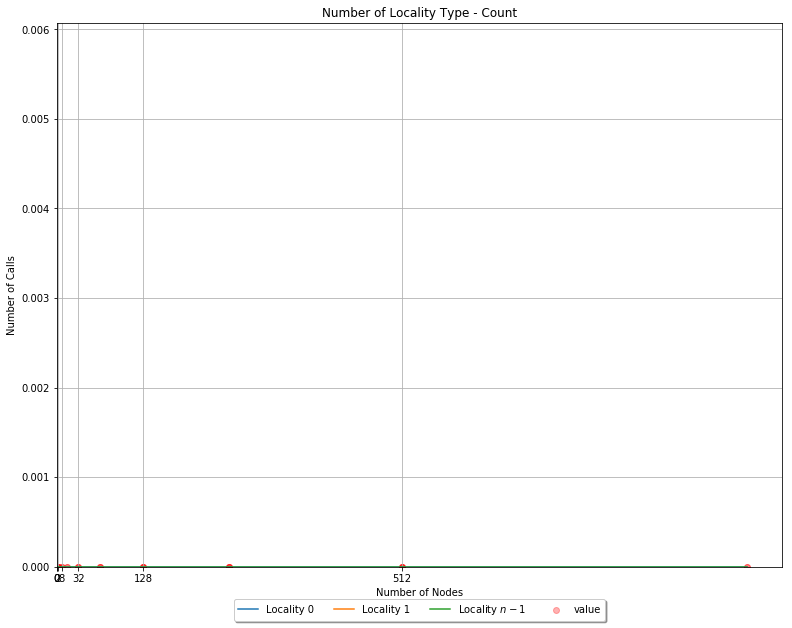

In [40]:
crt = d[(d.sys=='agas') & (d.proc=='num_localities_type') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Number of Locality Type - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

(0.0, 0.006070640176600442)

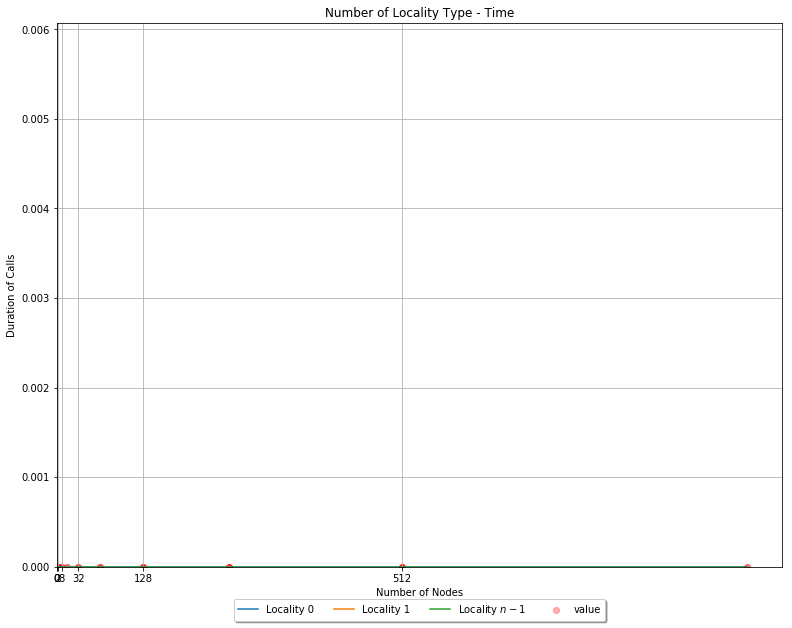

In [41]:
crt = d[(d.sys=='agas') & (d.proc=='num_localities_type') & (d.type=='time')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Number of Locality Type - Time')
plt.xlabel('Number of Nodes')
plt.ylabel('Duration of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

## Locality Namespace

### Free

(0.0, 0.006070640176600442)

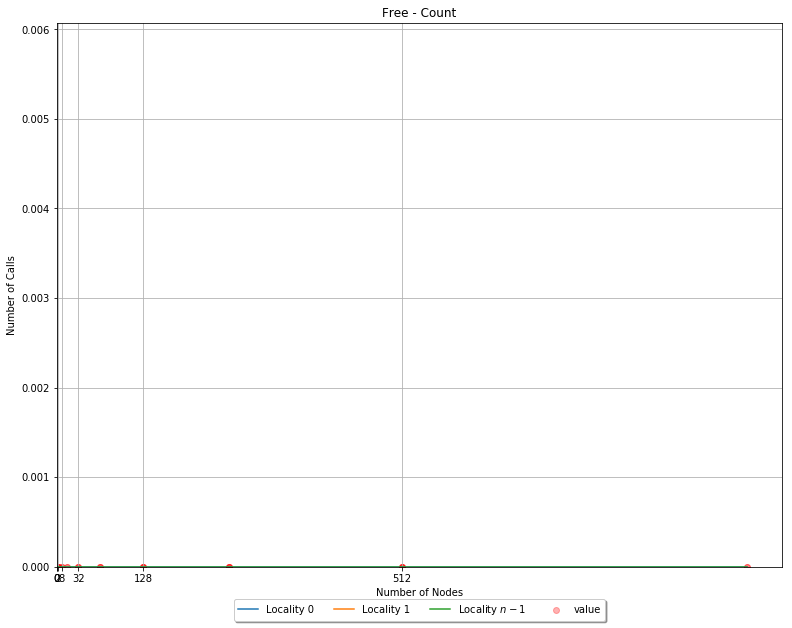

In [42]:
crt = d[(d.sys=='agas') & (d.proc=='free') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Free - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

(0.0, 0.006070640176600442)

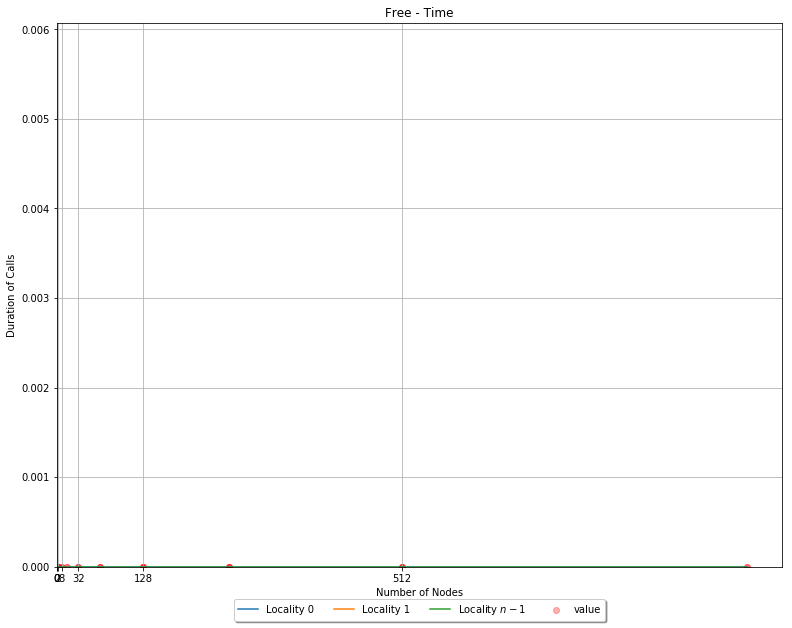

In [43]:
crt = d[(d.sys=='agas') & (d.proc=='free') & (d.type=='time')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Free - Time')
plt.xlabel('Number of Nodes')
plt.ylabel('Duration of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

### Localities

(0.0, 2.0060706401766)

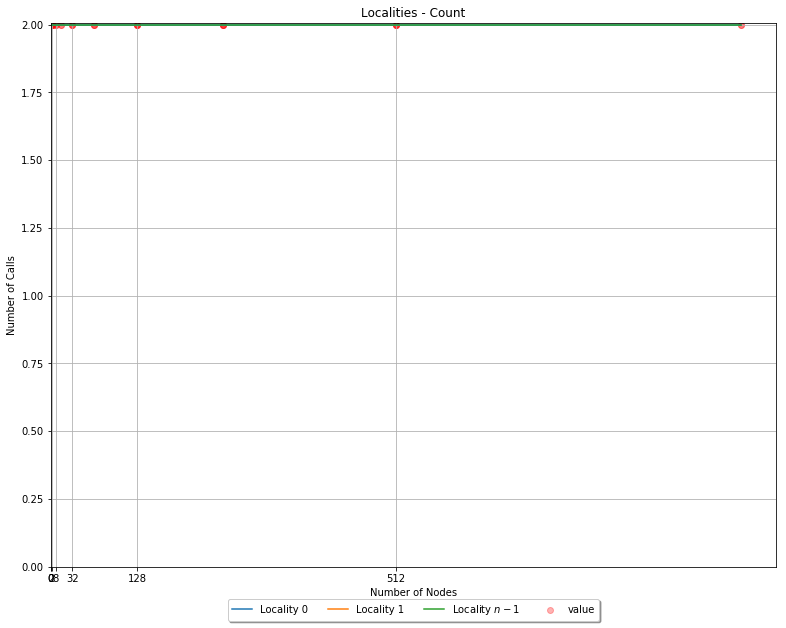

In [44]:
crt = d[(d.sys=='agas') & (d.proc=='localities') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Localities - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

(0.0, 93351.95607064017)

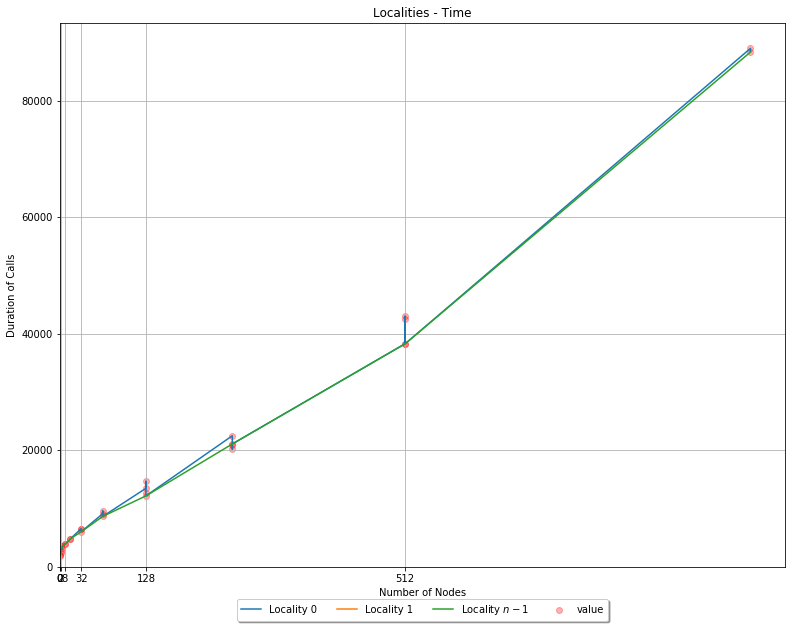

In [45]:
crt = d[(d.sys=='agas') & (d.proc=='localities') & (d.type=='time')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Localities - Time')
plt.xlabel('Number of Nodes')
plt.ylabel('Duration of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

### Number of Localities

(0.0, 29065.056070640177)

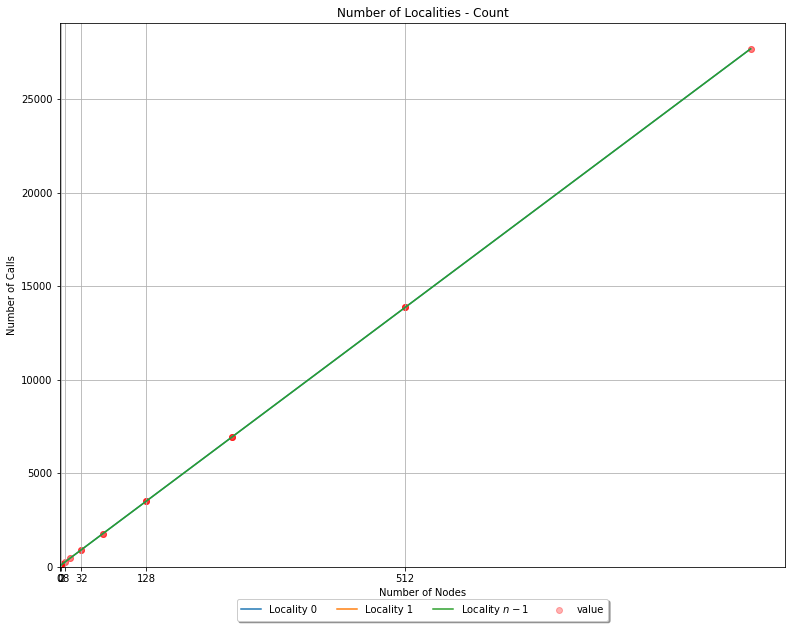

In [46]:
crt = d[(d.sys=='agas') & (d.proc=='num_localities') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Number of Localities - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

(0.0, 6979481.1060706405)

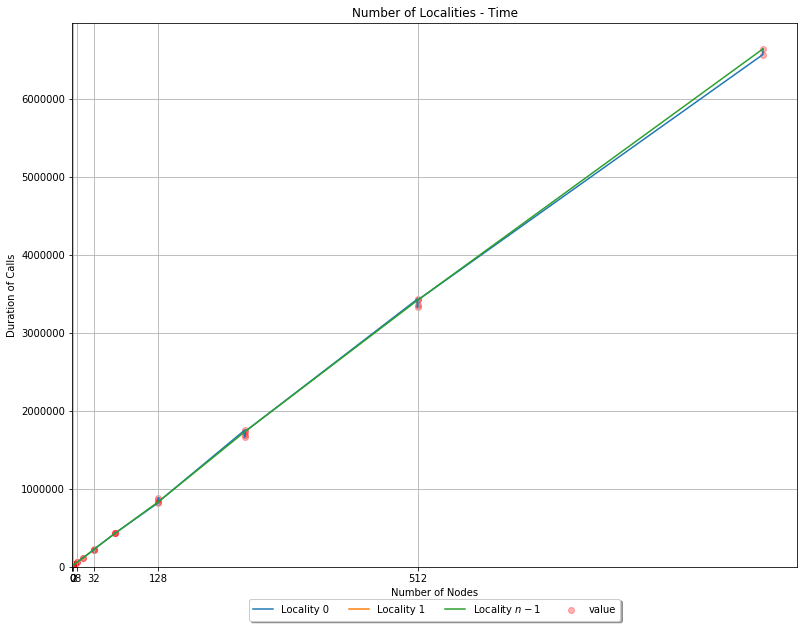

In [47]:
crt = d[(d.sys=='agas') & (d.proc=='num_localities') & (d.type=='time')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Number of Localities - Time')
plt.xlabel('Number of Nodes')
plt.ylabel('Duration of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

### Resolve Locality

(0.0, 0.006070640176600442)

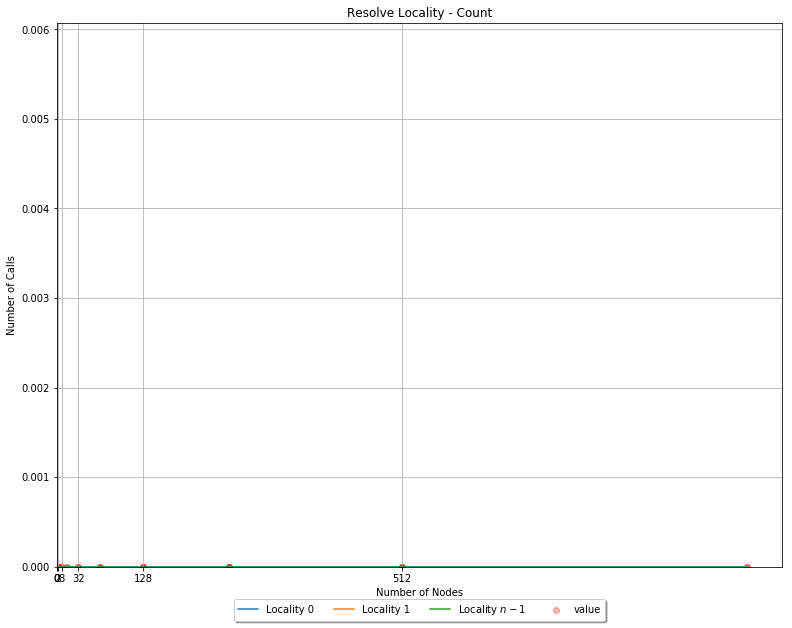

In [48]:
crt = d[(d.sys=='agas') & (d.proc=='resolve_locality') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Resolve Locality - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

(0.0, 0.006070640176600442)

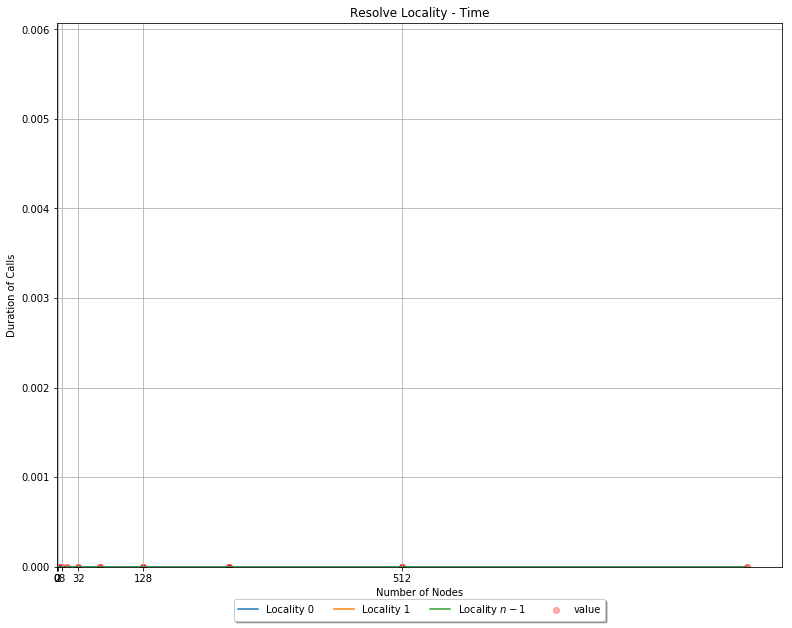

In [49]:
crt = d[(d.sys=='agas') & (d.proc=='resolve_locality') & (d.type=='time')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Resolve Locality - Time')
plt.xlabel('Number of Nodes')
plt.ylabel('Duration of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

### Number of Threads

(0.0, 0.006070640176600442)

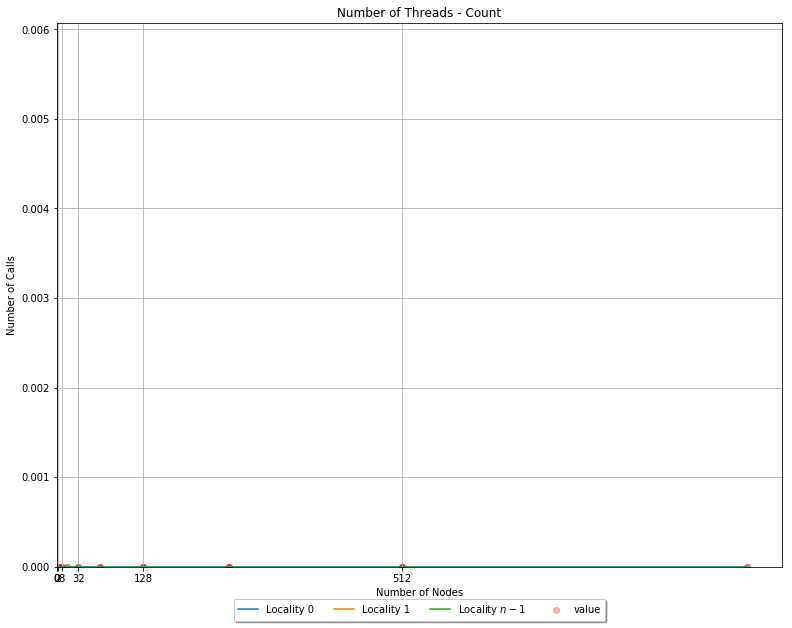

In [50]:
crt = d[(d.sys=='agas') & (d.proc=='num_threads') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Number of Threads - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

(0.0, 0.006070640176600442)

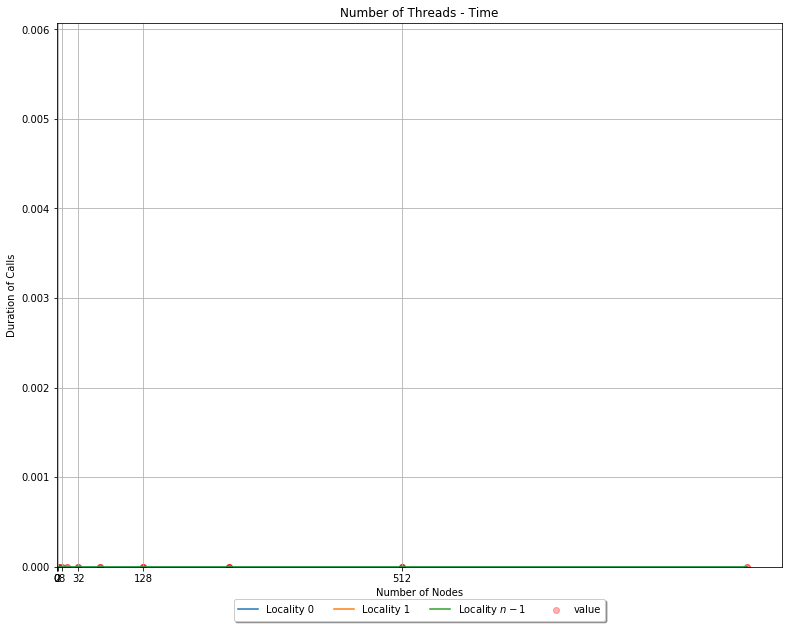

In [51]:
crt = d[(d.sys=='agas') & (d.proc=='num_threads') & (d.type=='time')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Number of Threads - Time')
plt.xlabel('Number of Nodes')
plt.ylabel('Duration of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

## Symbol Namespace

### Bind

(0.0, 46.7060706401766)

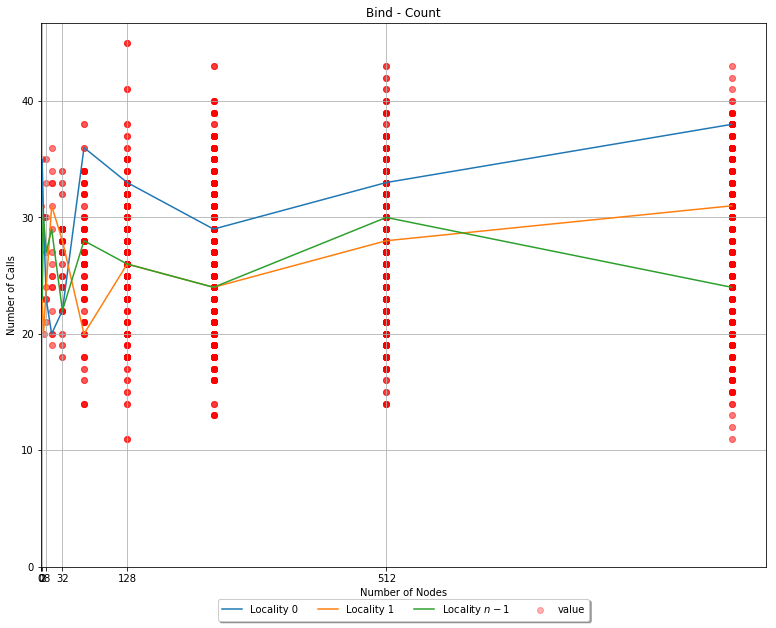

In [52]:
crt = d[(d.sys=='agas') & (d.proc=='bind') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Bind - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

(0.0, 118702.40607064018)

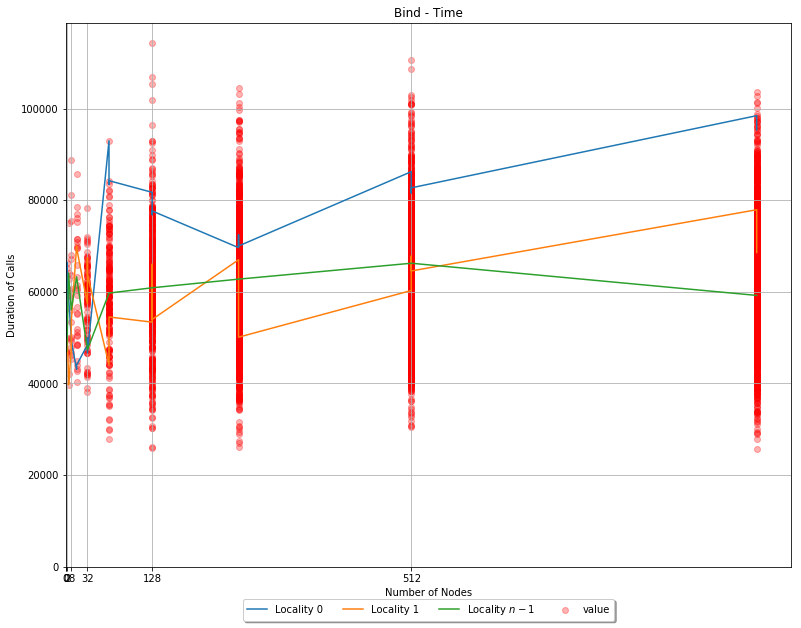

In [53]:
crt = d[(d.sys=='agas') & (d.proc=='bind') & (d.type=='time')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Bind - Time')
plt.xlabel('Number of Nodes')
plt.ylabel('Duration of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

### Unbind

(0.0, 0.006070640176600442)

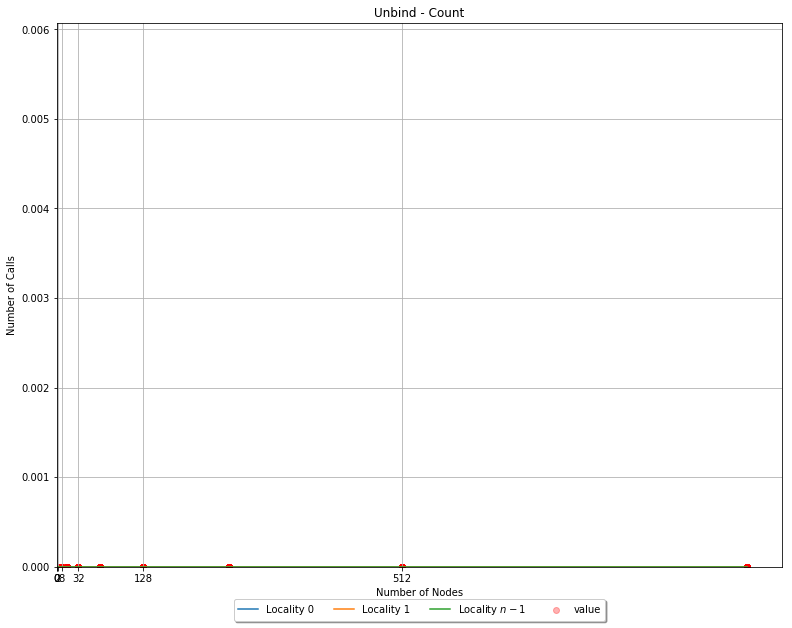

In [54]:
crt = d[(d.sys=='agas') & (d.proc=='unbind') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Unbind - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

(0.0, 0.006070640176600442)

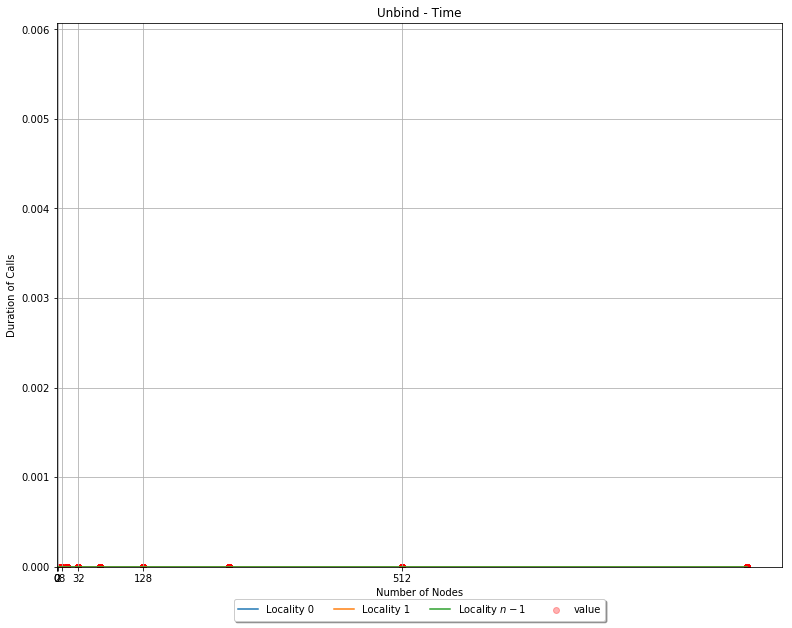

In [55]:
crt = d[(d.sys=='agas') & (d.proc=='unbind') & (d.type=='time')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Unbind - Time')
plt.xlabel('Number of Nodes')
plt.ylabel('Duration of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

### Resolve

(0.0, 10789.406070640176)

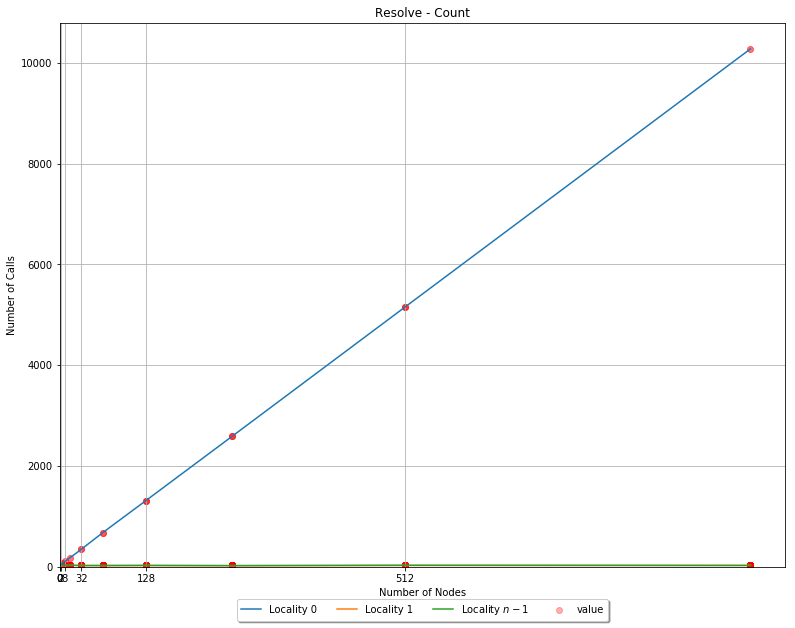

In [56]:
crt = d[(d.sys=='agas') & (d.proc=='resolve') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Resolve - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

(0.0, 29128784.00607064)

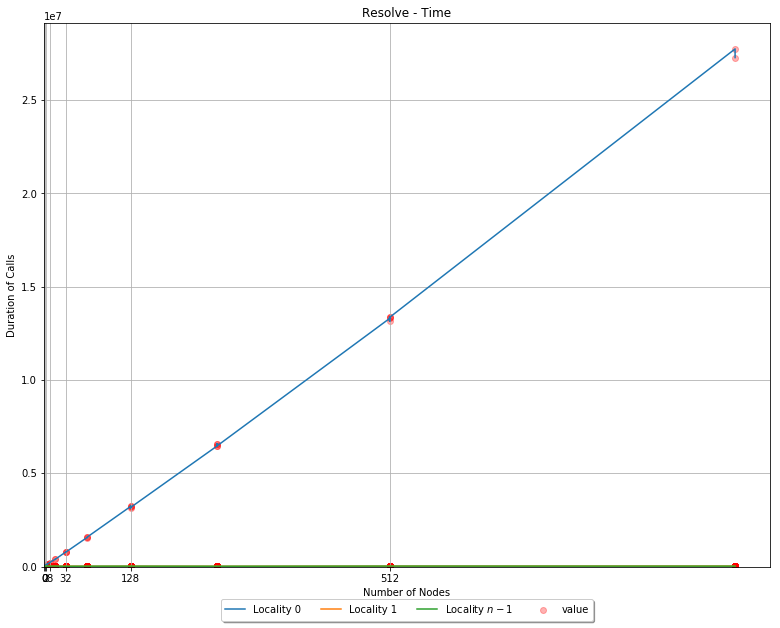

In [57]:
crt = d[(d.sys=='agas') & (d.proc=='resolve') & (d.type=='time')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Resolve - Time')
plt.xlabel('Number of Nodes')
plt.ylabel('Duration of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

### Iterate Names

(0.0, 0.006070640176600442)

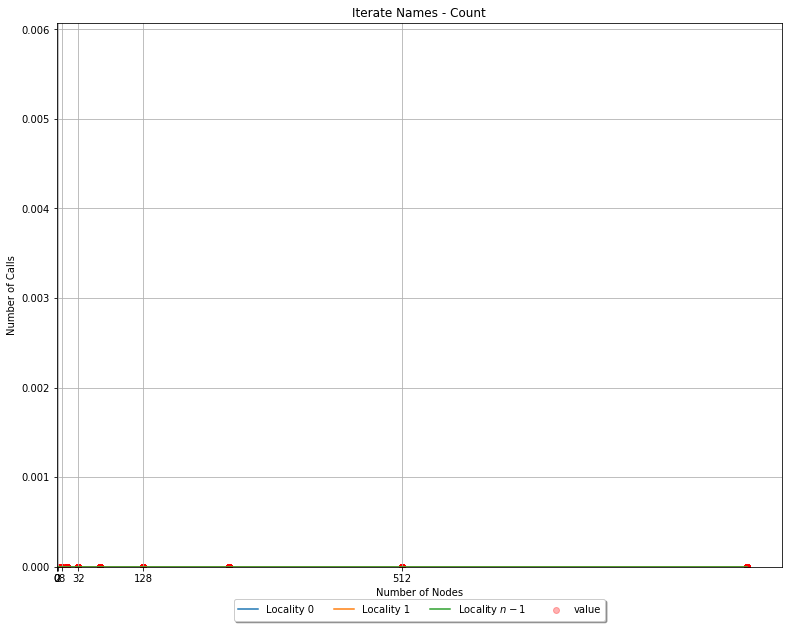

In [58]:
crt = d[(d.sys=='agas') & (d.proc=='iterate_names') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Iterate Names - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

(0.0, 0.006070640176600442)

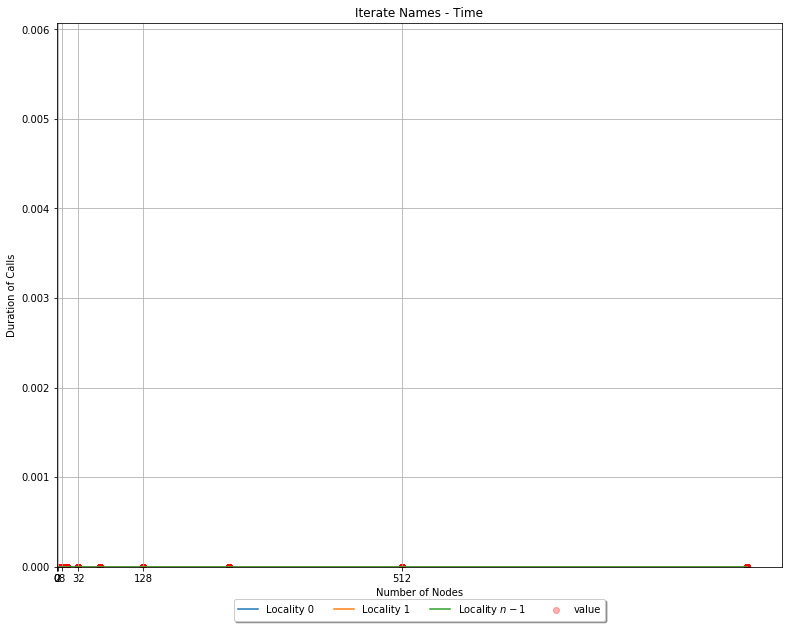

In [59]:
crt = d[(d.sys=='agas') & (d.proc=='iterate_names') & (d.type=='time')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Iterate Names - Time')
plt.xlabel('Number of Nodes')
plt.ylabel('Duration of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

### On Symbol Namespace Event

(0.0, 0.006070640176600442)

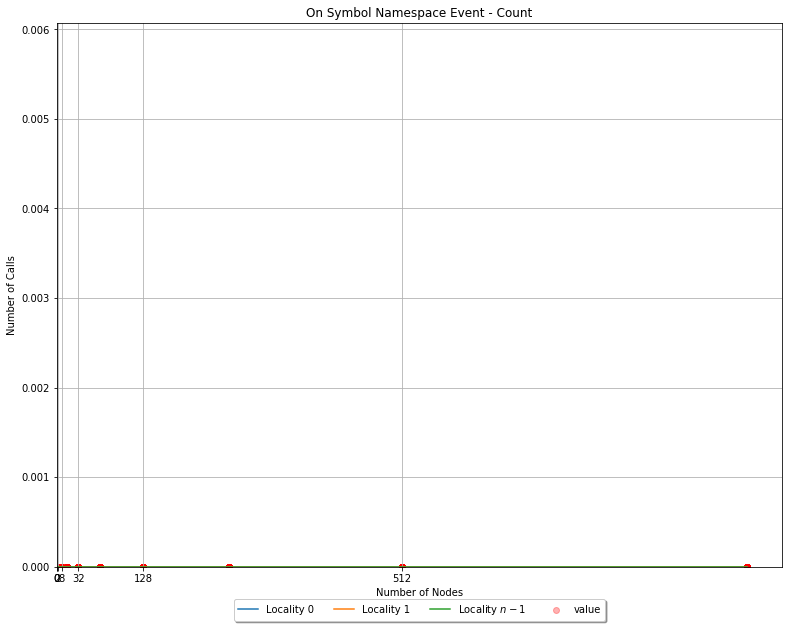

In [60]:
crt = d[(d.sys=='agas') & (d.proc=='on_symbol_namespace_event') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('On Symbol Namespace Event - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

(0.0, 0.006070640176600442)

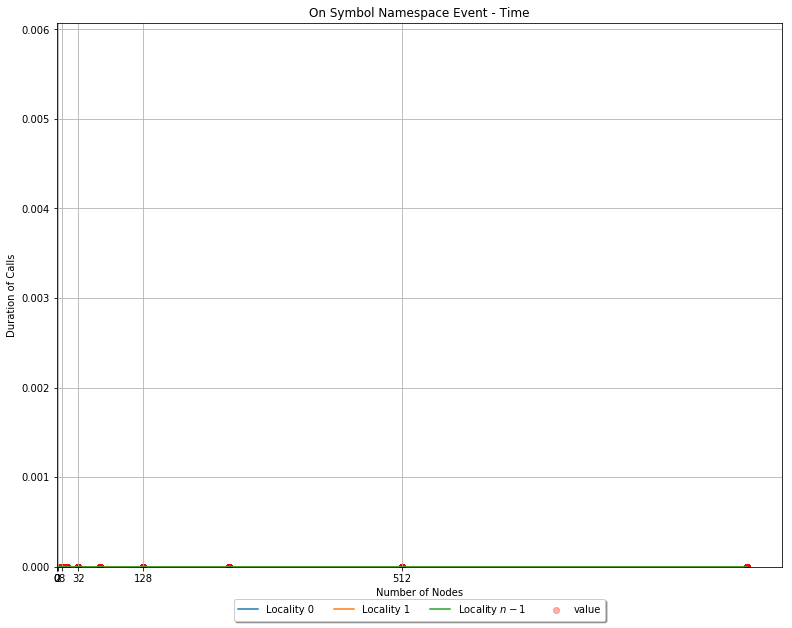

In [61]:
crt = d[(d.sys=='agas') & (d.proc=='on_symbol_namespace_event') & (d.type=='time')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('On Symbol Namespace Event - Time')
plt.xlabel('Number of Nodes')
plt.ylabel('Duration of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

---

## AGAS Cache

### Number of Cache Entries

(0.0, 4300.806070640176)

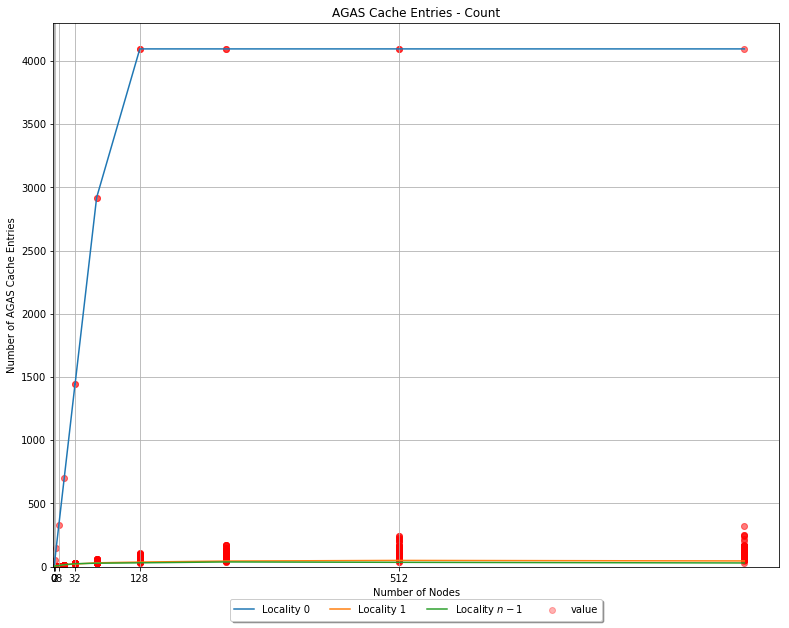

In [62]:
crt = d[(d.sys=='agas') & (d.proc=='cache.entries') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('AGAS Cache Entries - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of AGAS Cache Entries')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

### AGAS Cache Insertions

(0.0, 128948.4060706402)

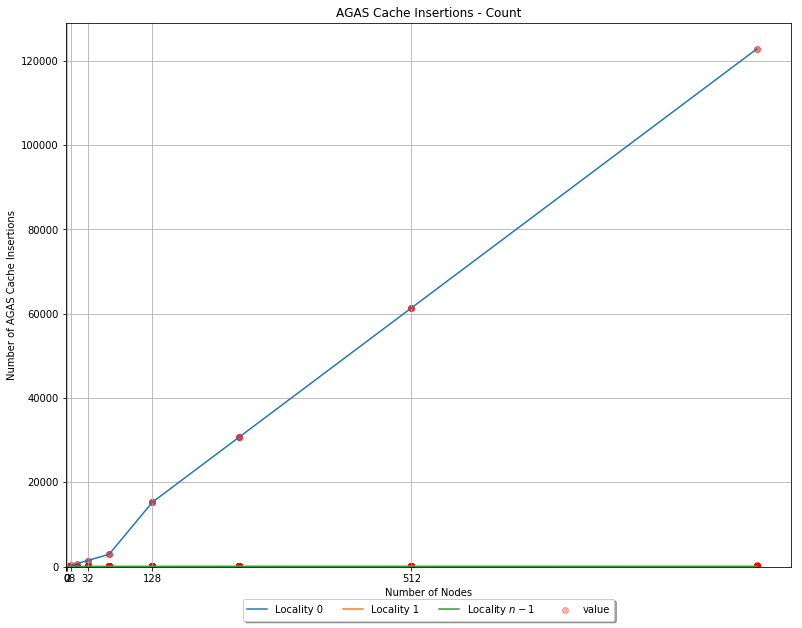

In [63]:
crt = d[(d.sys=='agas') & (d.proc=='cache.insertions') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('AGAS Cache Insertions - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of AGAS Cache Insertions')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

### AGAS Cache Evictions

(0.0, 125721.75607064017)

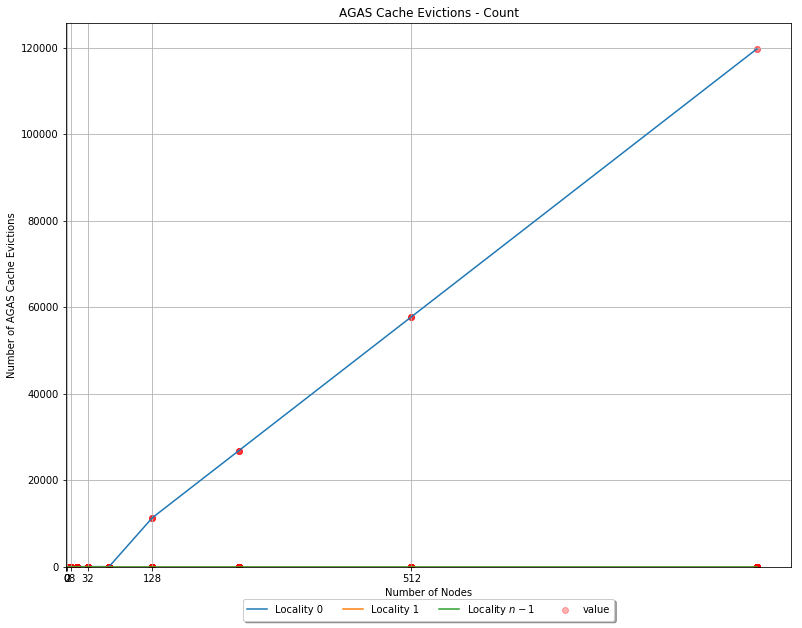

In [259]:
crt = d[(d.sys=='agas') & (d.proc=='cache.evictions') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('AGAS Cache Evictions - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of AGAS Cache Evictions')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

### AGAS Cache Hit Rate

* $\textit{hits}$: `/agas{locality#*/total}/count/cache/hits`
* $\textit{misses}$: `/agas{locality#*/total}/count/cache/misses`

$$
\textit{miss rate} = \frac{\textit{misses}}{\textit{misses} + \textit{hits}}
$$

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(0.0, 1.0463009237878382)

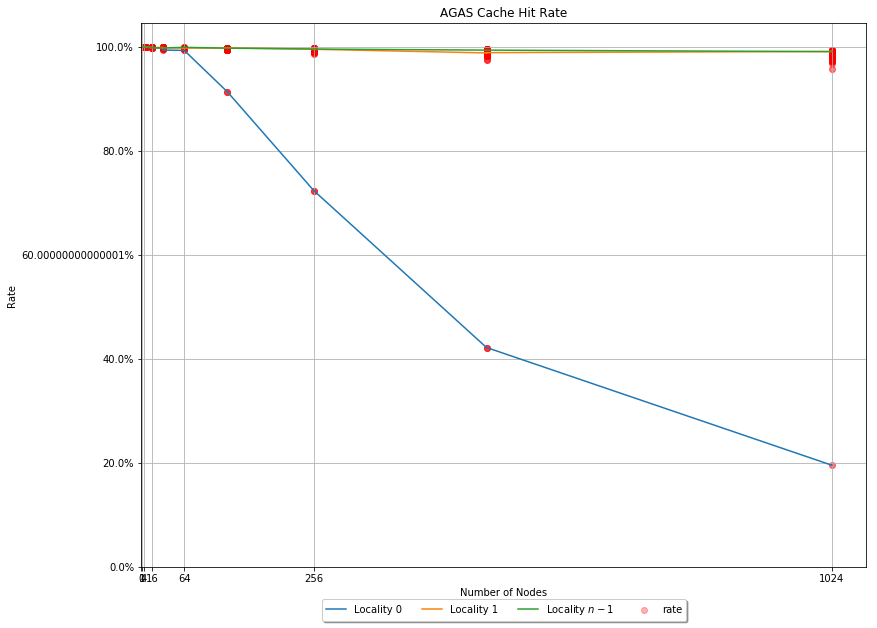

In [311]:
crt_h = d[(d.sys=='agas') & (d.proc=='cache.hits') & (d.type=='count')]
crt_m = d[(d.sys=='agas') & (d.proc=='cache.misses') & (d.type=='count')]

crt_m = crt_m.set_index(crt_h.index)

crt = crt_h[['nodes', 'value', 'locality']]
#crt.is_copy = False # Disable the warning
crt['rate'] = crt_h.value / (crt_h.value + crt_m.value)

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.rate, c='r', alpha=.3)

t = crt[crt.locality==0]
plt.plot(t.nodes, t.rate, label='Locality 0')

t = crt[crt.locality==1]
plt.plot(t.nodes, t.rate, label='Locality 1')

t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.rate, label='Locality $n - 1$')

plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('AGAS Cache Hit Rate')
plt.xlabel('Number of Nodes')
plt.ylabel('Rate')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().yaxis.set_major_formatter(PercentFormatter)
plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

### Get Entry

(0.0, 480072600.0060706)

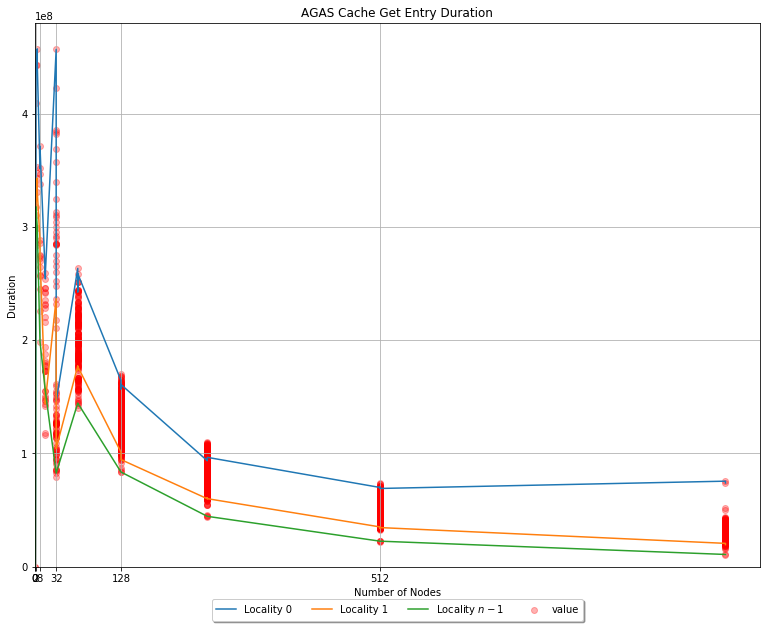

In [66]:
crt = d[(d.sys=='agas') & (d.proc=='cache.get_entry') & (d.type=='time')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)

t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')

t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('AGAS Cache Get Entry Duration')
plt.xlabel('Number of Nodes')
plt.ylabel('Duration')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

### Insert Entry

(0.0, 207388650.00607064)

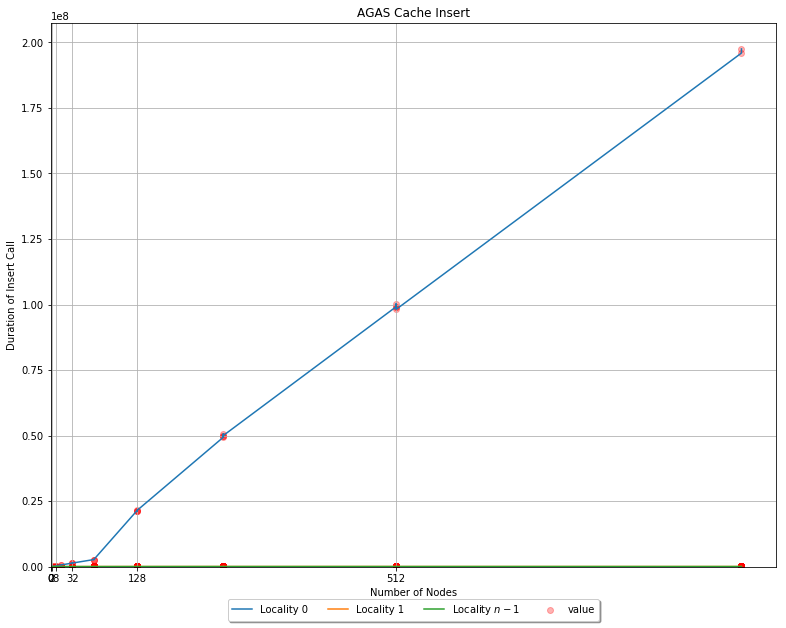

In [67]:
crt = d[(d.sys=='agas') & (d.proc=='cache.insert_entry') & (d.type=='time')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)

t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')

t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('AGAS Cache Insert')
plt.xlabel('Number of Nodes')
plt.ylabel('Duration of Insert Call')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

### Update Entry

(0.0, 137576.25607064017)

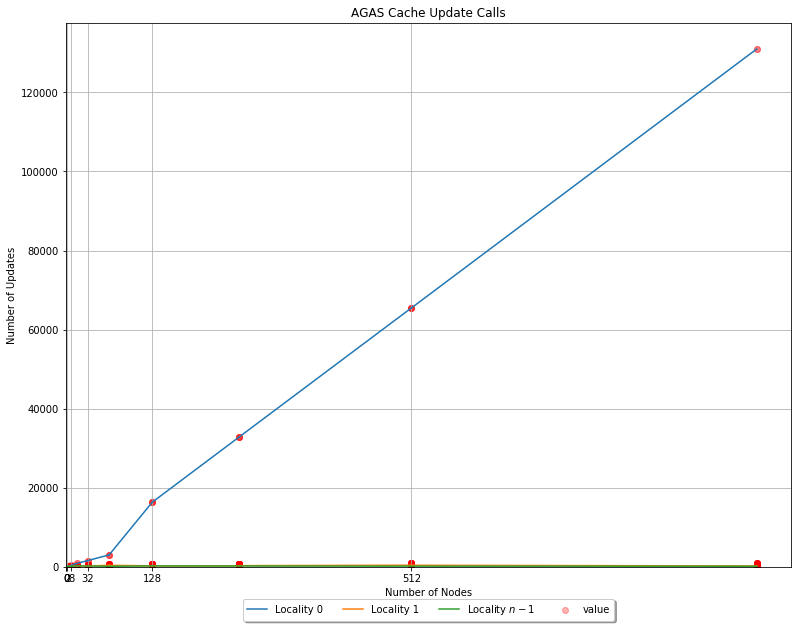

In [68]:
crt = d[(d.sys=='agas') & (d.proc=='cache.update_entry') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)

t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')

t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('AGAS Cache Update Calls')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Updates')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

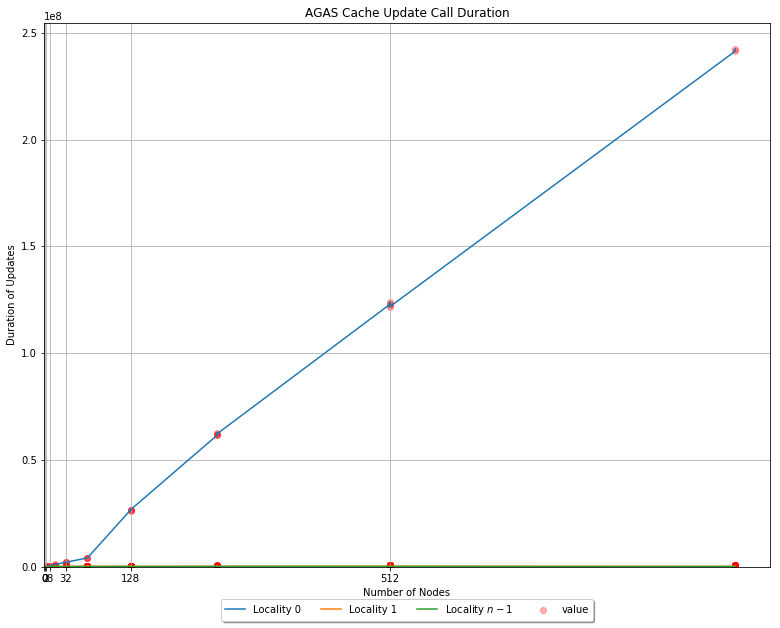

In [69]:
crt = d[(d.sys=='agas') & (d.proc=='cache.update_entry') & (d.type=='time')]

if crt.size > 0:
    plt.figure(figsize=(13, 10))
    plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)

    t = crt[crt.locality==0]
    plt.plot(t.nodes, t.value, label='Locality 0')

    t = crt[crt.locality==1]
    plt.plot(t.nodes, t.value, label='Locality 1')
    #
    t = crt.groupby('nodes', as_index=False).last()
    plt.plot(t.nodes, t.value, label='Locality $n - 1$')
    #
    plt.grid()

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
    plt.title('AGAS Cache Update Call Duration')
    plt.xlabel('Number of Nodes')
    plt.ylabel('Duration of Updates')

    plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
    plt.gca().set_xlim(left=0.)
    plt.gca().set_ylim(bottom=0.)

### Erase Entry

(0.0, 0.006070640176600442)

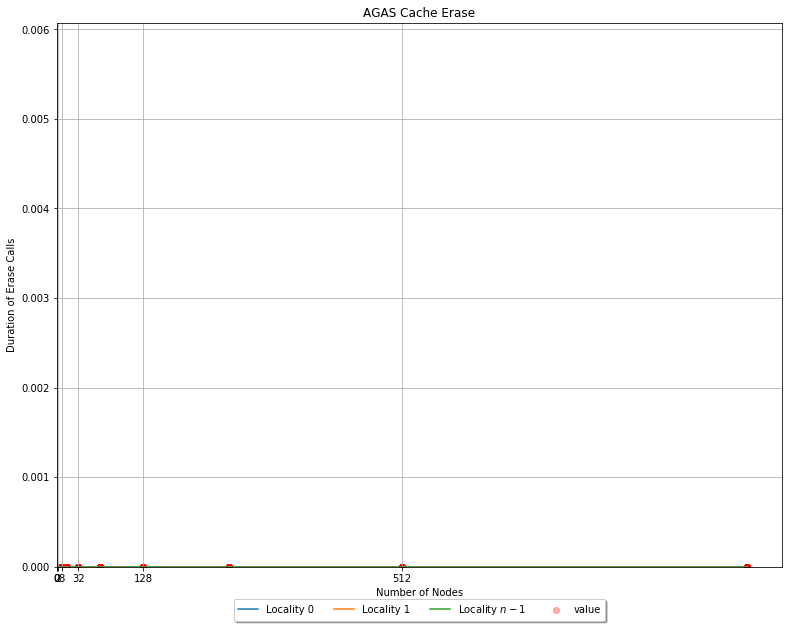

In [70]:
crt = d[(d.sys=='agas') & (d.proc=='cache.erase_entry') & (d.type=='time')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)

t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')

t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('AGAS Cache Erase')
plt.xlabel('Number of Nodes')
plt.ylabel('Duration of Erase Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

***

## Overview

### Primary Namespace

(0.0, 44914997.25607064)

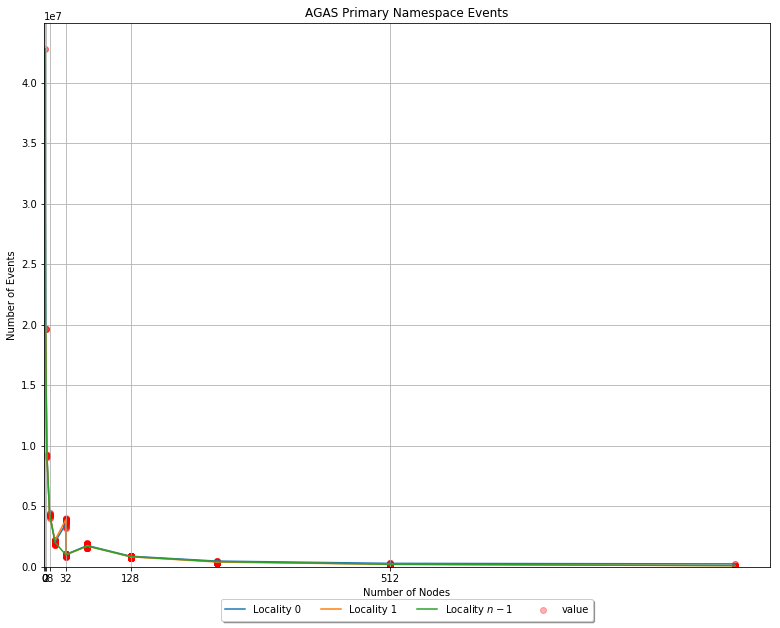

In [71]:
crt = d[(d.sys=='agas') & (d.proc=='primary') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)

t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')

t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('AGAS Primary Namespace Events')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Events')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

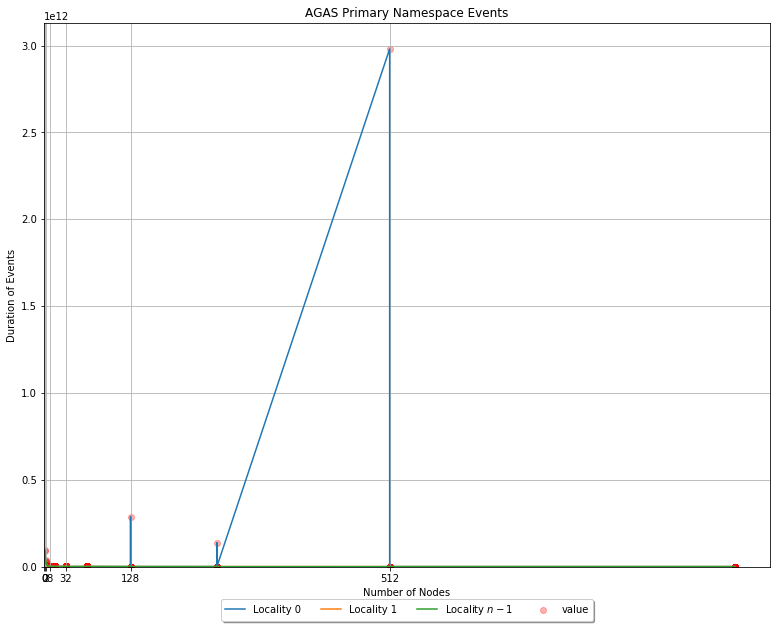

In [72]:
crt = d[(d.sys=='agas') & (d.proc=='primary') & (d.type=='time')]

if crt.size > 0:
    plt.figure(figsize=(13, 10))
    plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)

    t = crt[crt.locality==0]
    plt.plot(t.nodes, t.value, label='Locality 0')

    t = crt[crt.locality==1]
    plt.plot(t.nodes, t.value, label='Locality 1')
    #
    t = crt.groupby('nodes', as_index=False).last()
    plt.plot(t.nodes, t.value, label='Locality $n - 1$')
    #
    plt.grid()

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
    plt.title('AGAS Primary Namespace Events')
    plt.xlabel('Number of Nodes')
    plt.ylabel('Duration of Events')

    plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
    plt.gca().set_xlim(left=0.)
    plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

### Component Namespace

(0.0, 0.006070640176600442)

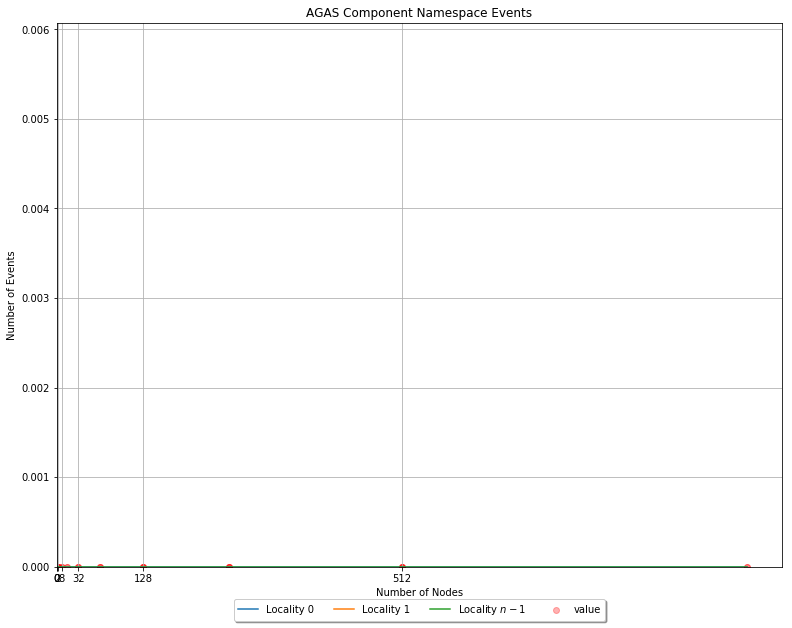

In [73]:
crt = d[(d.sys=='agas') & (d.proc=='component') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)

t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')

t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('AGAS Component Namespace Events')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Events')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

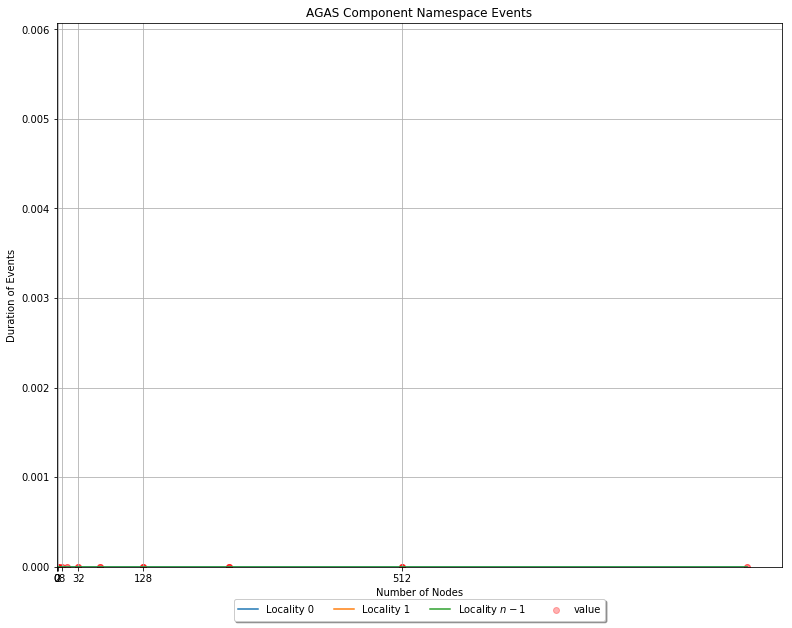

In [74]:
crt = d[(d.sys=='agas') & (d.proc=='component') & (d.type=='time')]

if crt.size > 0:
    plt.figure(figsize=(13, 10))
    plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)

    t = crt[crt.locality==0]
    plt.plot(t.nodes, t.value, label='Locality 0')

    t = crt[crt.locality==1]
    plt.plot(t.nodes, t.value, label='Locality 1')
    #
    t = crt.groupby('nodes', as_index=False).last()
    plt.plot(t.nodes, t.value, label='Locality $n - 1$')
    #
    plt.grid()

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
    plt.title('AGAS Component Namespace Events')
    plt.xlabel('Number of Nodes')
    plt.ylabel('Duration of Events')

    plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
    plt.gca().set_xlim(left=0.)
    plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

### Locality Namespace

(0.0, 29067.05607064018)

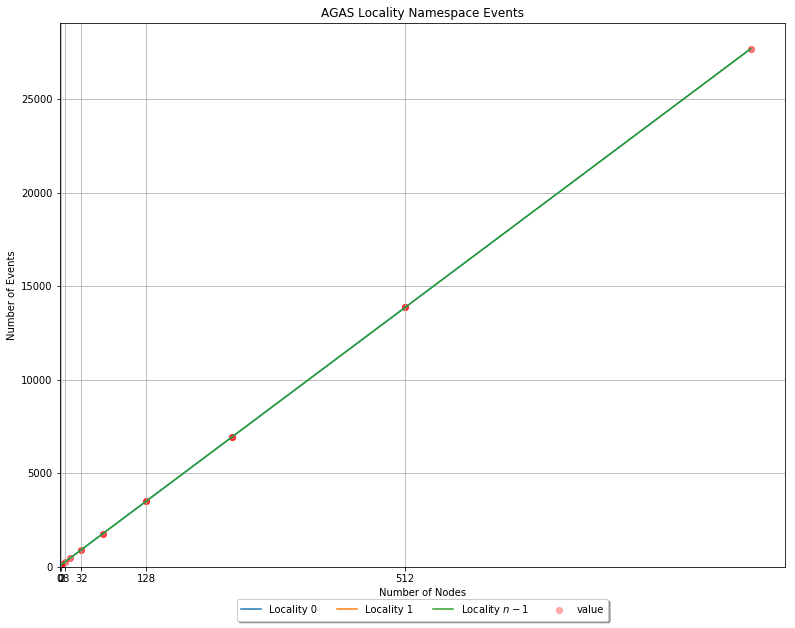

In [75]:
crt = d[(d.sys=='agas') & (d.proc=='locality') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)

t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')

t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('AGAS Locality Namespace Events')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Events')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

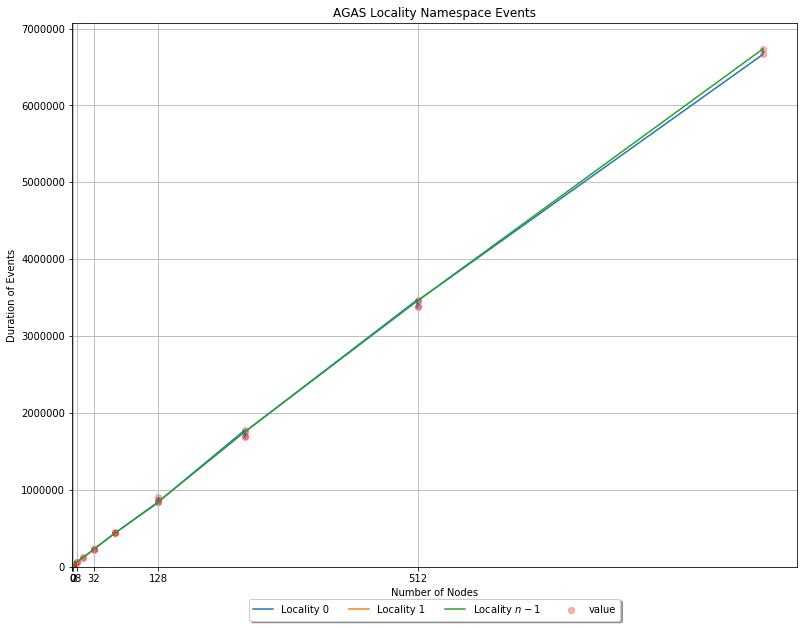

In [76]:
crt = d[(d.sys=='agas') & (d.proc=='locality') & (d.type=='time')]

if crt.size > 0:
    plt.figure(figsize=(13, 10))
    plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)

    t = crt[crt.locality==0]
    plt.plot(t.nodes, t.value, label='Locality 0')

    t = crt[crt.locality==1]
    plt.plot(t.nodes, t.value, label='Locality 1')
    #
    t = crt.groupby('nodes', as_index=False).last()
    plt.plot(t.nodes, t.value, label='Locality $n - 1$')
    #
    plt.grid()

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
    plt.title('AGAS Locality Namespace Events')
    plt.xlabel('Number of Nodes')
    plt.ylabel('Duration of Events')

    plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
    plt.gca().set_xlim(left=0.)
    plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

### Symbol Namespace

(0.0, 10828.756070640176)

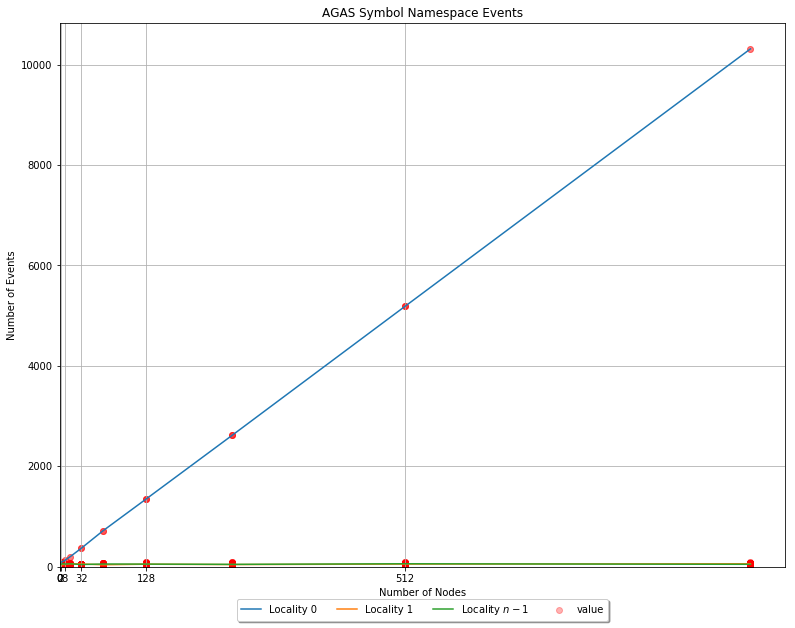

In [77]:
crt = d[(d.sys=='agas') & (d.proc=='symbol') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)

t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')

t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('AGAS Symbol Namespace Events')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Events')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

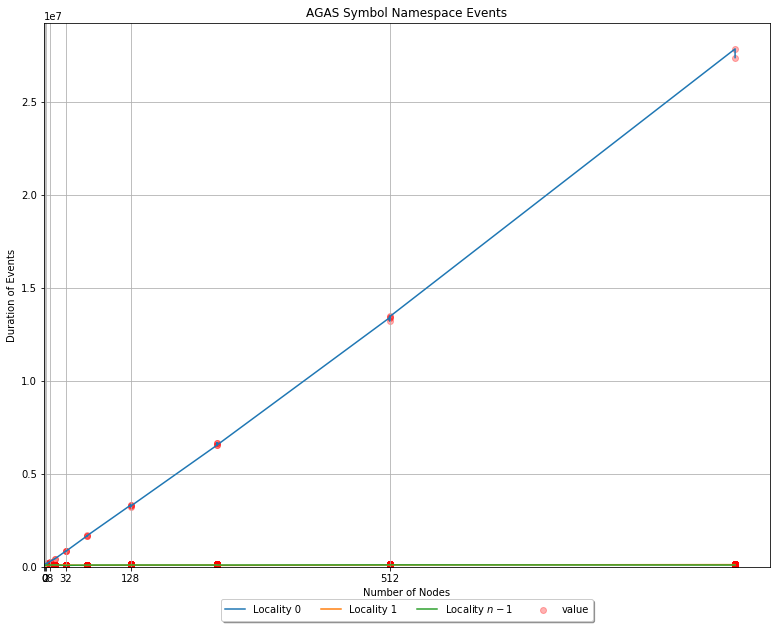

In [78]:
crt = d[(d.sys=='agas') & (d.proc=='symbol') & (d.type=='time')]

if crt.size > 0:
    plt.figure(figsize=(13, 10))
    plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)

    t = crt[crt.locality==0]
    plt.plot(t.nodes, t.value, label='Locality 0')

    t = crt[crt.locality==1]
    plt.plot(t.nodes, t.value, label='Locality 1')
    #
    t = crt.groupby('nodes', as_index=False).last()
    plt.plot(t.nodes, t.value, label='Locality $n - 1$')
    #
    plt.grid()

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
    plt.title('AGAS Symbol Namespace Events')
    plt.xlabel('Number of Nodes')
    plt.ylabel('Duration of Events')

    plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
    plt.gca().set_xlim(left=0.)
    plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

---

# Miscellaneous

### Save Dataset to disk

```python
df.to_hdf('./pfx_data.hdf', 'table', mode='w', table=True)
```

[^ TOC ^](#Counters)